In [35]:
# 1. 라이브러리 설치 및 불러오기
!pip install -q seaborn
!pip install scikeras

# 나눔고딕 폰트 설치 및 설정
!apt-get update -qq
!apt-get install fonts-nanum -qq
!fc-cache -fv
!rm ~/.cache/matplotlib -rf

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped dire

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [37]:
# 폰트 설정
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=10)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
# 데이터 불러오기
file_path = "/content/drive/MyDrive/4조/휴게_일반_영업_폐업_데이터/일반_휴게_통합_카페_데이터.csv"
df = pd.read_csv(file_path, encoding="utf-8")
# file_path = "/content/일반음식점(카페)현황.csv"
# df = pd.read_csv(file_path, encoding="cp949")

print(df.shape)
print(df.isna().sum())
print(df.head())

# # 마스킹 셀 제거
# df = df[~df.apply(lambda row: row.astype(str).str.contains('#').any(), axis=1)]

# # 불필요한 열 제거
# drop_cols = ['사업장명', '총시설규모(㎡)', '위생업태명', '소재지도로명주소', '소재지지번주소', '소재지우편번호', 'WGS84위도', 'WGS84경도']
# df = df.drop(columns=drop_cols)

# # ✅ 날짜 포맷 혼합 처리 함수
# def parse_yyyymmdd(val):
#     try:
#         val_str = str(val)
#         if len(val_str) == 8 and val_str.isdigit():
#             return pd.to_datetime(val_str, format="%Y%m%d", errors='coerce')
#         return pd.to_datetime(val, errors='coerce')
#     except:
#         return pd.NaT

# # 날짜 컬럼 전처리
# df['인허가일자'] = df['인허가일자'].apply(parse_yyyymmdd)
# df['폐업일자'] = df['폐업일자'].apply(parse_yyyymmdd)

# # 연도 추출
# df['인허가연도'] = df['인허가일자'].dt.year
# df = df[df['인허가연도'].notna()].copy()
# df['인허가연도'] = df['인허가연도'].astype(int)

# # 폐업연도 추출
# df['폐업연도'] = df.apply(
#     lambda row: row['폐업일자'].year if row['영업상태명'] == '폐업' and pd.notna(row['폐업일자']) else None,
#     axis=1
# )

# # ✅ 6개 도시만 필터링
# target_cities = ['부천시', '수원시', '안산시', '안양시', '용인시', '화성시']
# df = df[df['시군명'].isin(target_cities)]



(15959, 25)
인허가일자           0
인허가취소일자     15959
영업상태구분코드        0
영업상태명           0
상세영업상태코드        0
상세영업상태명         0
폐업일자         7159
휴업시작일자      15959
휴업종료일자      15959
재개업일자       15959
소재지전체주소         0
도로명전체주소         0
업태구분명           0
사업장명            0
데이터갱신일자         0
소재지면적           0
lon           880
lat           880
폐업여부            0
폐업연도         7159
인허가연도           0
영업기간(일)      7159
직원수             0
시군명             0
프랜차이즈           0
dtype: int64
        인허가일자  인허가취소일자  영업상태구분코드  영업상태명  상세영업상태코드 상세영업상태명 폐업일자  휴업시작일자  \
0  2015-05-06      NaN         1  영업/정상         1      영업  NaN     NaN   
1  2015-05-01      NaN         1  영업/정상         1      영업  NaN     NaN   
2  2015-03-27      NaN         1  영업/정상         1      영업  NaN     NaN   
3  2015-03-19      NaN         1  영업/정상         1      영업  NaN     NaN   
4  2015-03-04      NaN         1  영업/정상         1      영업  NaN     NaN   

   휴업종료일자  재개업일자  ...   소재지면적         lon        lat 폐업여부 폐업연도  인허가연도  \
0     N

In [40]:
# 연도 범위 설정 - 2016년 이후만
min_year = 2016
max_year = int(df['폐업연도'].dropna().max()) if not df['폐업연도'].dropna().empty else int(df['인허가연도'].max())
year_range = range(min_year, max_year + 1)

# ✅ 올바른 폐업률 계산
result = []
for region in df['시군명'].dropna().unique():
    region_df = df[df['시군명'] == region]

    for year in year_range:
        # 개인/프랜차이즈별 집계
        for franchise_status, label in [(0, '개인'), (1, '프랜차이즈')]:
            f_df = region_df[region_df['프랜차이즈'] == franchise_status]

            operating_stores = f_df[
                (f_df['인허가연도'] <= year) &
                (
                    (f_df['폐업연도'].isnull()) |
                    (f_df['폐업연도'] >= year)
                )
            ].shape[0]

            closed_stores = f_df[f_df['폐업연도'] == year].shape[0]

            closure_rate = (closed_stores / operating_stores * 100) if operating_stores > 0 else 0

            stores_at_start = f_df[
                (f_df['인허가연도'] < year) &
                (
                    (f_df['폐업연도'].isnull()) |
                    (f_df['폐업연도'] >= year)
                )
            ].shape[0]

            new_stores = f_df[f_df['인허가연도'] == year].shape[0]

            total_closed_until_year = f_df[
                (f_df['폐업연도'].notna()) &
                (f_df['폐업연도'] <= year)
            ].shape[0]

            opening_rate = (new_stores / stores_at_start * 100) if stores_at_start > 0 else 0

            result.append({
                '시군명': region,
                '년도': year,
                '구분': label,
                '운영점포수': operating_stores,
                '연초점포수': stores_at_start,
                '신규개업': new_stores,
                '개업률(%)': round(opening_rate, 1),
                '폐업건수': closed_stores,
                '폐업률(%)': round(closure_rate, 1),
                '누적폐업': total_closed_until_year
            })

        # 통합 집계 (프랜차이즈 구분 없이 전체)
        total_operating = region_df[
            (region_df['인허가연도'] <= year) &
            (
                (region_df['폐업연도'].isnull()) |
                (region_df['폐업연도'] >= year)
            )
        ].shape[0]

        total_closed = region_df[region_df['폐업연도'] == year].shape[0]

        total_closure_rate = (total_closed / total_operating * 100) if total_operating > 0 else 0

        total_stores_at_start = region_df[
            (region_df['인허가연도'] < year) &
            (
                (region_df['폐업연도'].isnull()) |
                (region_df['폐업연도'] >= year)
            )
        ].shape[0]

        total_new_stores = region_df[region_df['인허가연도'] == year].shape[0]

        total_cumulative_closed = region_df[
            (region_df['폐업연도'].notna()) &
            (region_df['폐업연도'] <= year)
        ].shape[0]

        total_opening_rate = (total_new_stores / total_stores_at_start * 100) if total_stores_at_start > 0 else 0

        result.append({
            '시군명': region,
            '년도': year,
            '구분': '통합',
            '운영점포수': total_operating,
            '연초점포수': total_stores_at_start,
            '신규개업': total_new_stores,
            '개업률(%)': round(total_opening_rate, 1),
            '폐업건수': total_closed,
            '폐업률(%)': round(total_closure_rate, 1),
            '누적폐업': total_cumulative_closed
        })

result_df = pd.DataFrame(result)

# 2016년 이후 전체 카페 중 폐업률
total_rows = result_df[result_df['구분'] == '통합']

total_closed = total_rows['폐업건수'].sum()
total_operating = total_rows['운영점포수'].sum()
total_closure_rate = (total_closed / total_operating * 100) if total_operating > 0 else 0

# 검증을 위한 출력
print("=== 전체 통계 (2016 ~ 2025) ===")
print(f"전체 통합 폐업률: {total_closure_rate:.2f}%")
print(f"평균 폐업률: {total_rows['폐업률(%)'].mean():.2f}%")
print(f"최대 폐업률: {total_rows['폐업률(%)'].max():.2f}%")

# 6개 시 전체에 대한 개인/프랜차이즈 폐업률
overall_rates = result_df.groupby('구분').agg({
    '폐업건수': 'sum',
    '운영점포수': 'sum'
}).reset_index()
overall_rates['폐업률(%)'] = (overall_rates['폐업건수'] / overall_rates['운영점포수'] * 100).round(2)
print("\n1. 6개 시 전체에 대한 개인/프랜차이즈 폐업률")
display(overall_rates)

#  6개 시 각각 개인+프랜차이즈 폐업률
per_region_total = result_df[result_df['구분'] == '통합'].groupby('시군명').agg({
    '폐업건수': 'sum',
    '운영점포수': 'sum'
}).reset_index()
per_region_total['폐업률(%)'] = (per_region_total['폐업건수'] / per_region_total['운영점포수'] * 100).round(2)
print("\n2. 6개 시 각각 개인+프랜차이즈 합산 폐업률")
display(per_region_total)

# 6개 시 각각 개인/프랜차이즈 폐업률
per_region_franchise = result_df[result_df['구분'] != '통합'].groupby(['시군명', '구분']).agg({
    '폐업건수': 'sum',
    '운영점포수': 'sum'
}).reset_index()
per_region_franchise['폐업률(%)'] = (per_region_franchise['폐업건수'] / per_region_franchise['운영점포수'] * 100).round(2)
print("\n3. 6개 시 각각 개인/프랜차이즈 폐업률")
display(per_region_franchise)

# 연도별 전체 현황
yearly_summary = result_df.groupby('년도').agg({
    '운영점포수': 'sum',
    '신규개업': 'sum',
    '폐업건수': 'sum'
}).reset_index()
yearly_summary['전체폐업률(%)'] = (yearly_summary['폐업건수'] / yearly_summary['운영점포수'] * 100).round(1)

print("\n=== 최근 10년 전체 현황 ===")
display(yearly_summary.tail(10))

# 이상치 확인 (운영점포 10개 이상인 경우만)
print("\n=== 높은 폐업률 사례 (운영점포 10개 이상) ===")
high_closure = result_df[(result_df['폐업률(%)'] >= 30) & (result_df['운영점포수'] >= 10)]
display(high_closure.sort_values('폐업률(%)', ascending=False).head(10))

# 저장
result_df.to_csv("시군별_연도별_카페_폐업률_계산.csv", index=False, encoding='utf-8-sig')

=== 전체 통계 (2016 ~ 2025) ===
전체 통합 폐업률: 11.58%
평균 폐업률: 11.40%
최대 폐업률: 16.50%

1. 6개 시 전체에 대한 개인/프랜차이즈 폐업률


,구분,폐업건수,운영점포수,폐업률(%)
0,개인,7872,60854,12.94
1,통합,8800,75975,11.58
2,프랜차이즈,928,15121,6.14



2. 6개 시 각각 개인+프랜차이즈 합산 폐업률


,시군명,폐업건수,운영점포수,폐업률(%)
0,부천시,1478,11868,12.45
1,수원시,2188,17954,12.19
2,안산시,966,9469,10.20
3,안양시,966,9199,10.50
4,용인시,1691,14566,11.61
5,화성시,1511,12919,11.70



3. 6개 시 각각 개인/프랜차이즈 폐업률


,시군명,구분,폐업건수,운영점포수,폐업률(%)
0,부천시,개인,1331,9262,14.37
1,부천시,프랜차이즈,147,2606,5.64
2,수원시,개인,1969,14512,13.57
3,수원시,프랜차이즈,219,3442,6.36
4,안산시,개인,867,7595,11.42
5,안산시,프랜차이즈,99,1874,5.28
6,안양시,개인,869,7433,11.69
7,안양시,프랜차이즈,97,1766,5.49
8,용인시,개인,1494,11826,12.63
9,용인시,프랜차이즈,197,2740,7.19



=== 최근 10년 전체 현황 ===


,년도,운영점포수,신규개업,폐업건수,전체폐업률(%)
0,2016,12082,2120,1398,11.6
1,2017,12612,1928,1538,12.2
2,2018,13560,2486,1688,12.4
3,2019,14520,2648,1614,11.1
4,2020,15606,2700,1762,11.3
5,2021,16742,2898,1750,10.5
6,2022,17474,2482,2068,11.8
7,2023,17420,2014,2476,14.2
8,2024,16650,1706,2340,14.1
9,2025,15284,974,966,6.3



=== 높은 폐업률 사례 (운영점포 10개 이상) ===


,시군명,년도,구분,운영점포수,연초점포수,신규개업,개업률(%),폐업건수,폐업률(%),누적폐업


In [41]:
pivot = pd.pivot_table(result_df, values='폐업률(%)', index=['시군명', '구분'], columns='년도')

display(pivot)

년도         2016  2017  2018  2019  2020  2021  2022  2023  2024  2025
시군명 구분                                                               
부천시 개인      9.0  13.5  14.8  14.5  13.4  14.6  13.6  19.5  20.1   8.8
    통합      8.7  12.2  13.5  13.0  11.3  12.8  11.8  16.5  16.1   6.9
    프랜차이즈   7.0   5.6   7.4   6.3   3.2   6.5   6.0   7.5   5.5   2.7
수원시 개인     13.1  13.5  13.0  12.4  13.7  11.2  14.3  17.2  17.9   8.2
    통합     11.8  12.8  12.4  11.2  12.0  10.1  13.1  15.5  15.1   7.1
    프랜차이즈   4.5   9.2   9.3   5.1   3.7   5.3   8.0   9.0   6.1   3.8
안산시 개인     12.0   8.6  11.6   8.4  13.4  11.4  13.6  14.4  13.5   5.9
    통합     11.0   8.1  10.5   8.3  11.9  10.5  11.4  12.8  11.2   5.4
    프랜차이즈   4.5   5.1   4.0   8.0   4.2   6.8   3.5   7.8   4.6   4.2
안양시 개인     11.4  17.1   9.6  11.2  12.6   8.0  11.2  14.2  14.3   7.0
    통합     10.7  15.8   8.7  10.0  11.8   7.6  10.3  12.1  12.0   6.0
    프랜차이즈   6.5   9.2   4.4   4.1   8.0   6.2   6.6   4.3   4.6   3.3
용인시 개인     14.1  13.3  13.0  12.6  12.6  11.3  13.0  14.5  15.4   6.5
    통합     14.0  12.3  13.2  11.7  11.1  10.2  11.8  13.5  13.5   5.3
    프랜차이즈  13.2   6.8  14.2   7.4   4.0   5.8   7.1   9.7   7.0   1.5
화성시 개인     13.2  12.1  16.0  12.9  10.6  11.7  12.9  15.3  17.7   8.4
    통합     12.6  11.2  14.9  11.3   9.8  10.9  11.5  13.7  14.8   6.7
    프랜차이즈   9.6   6.8   9.5   4.2   6.5   7.5   6.2   8.4   5.9   2.2

/tmp/ipython-input-1378127251.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  barplot = sns.barplot(data=yearly, x='년도', y='폐업률(%)', color='#1f77b4', ci=None)


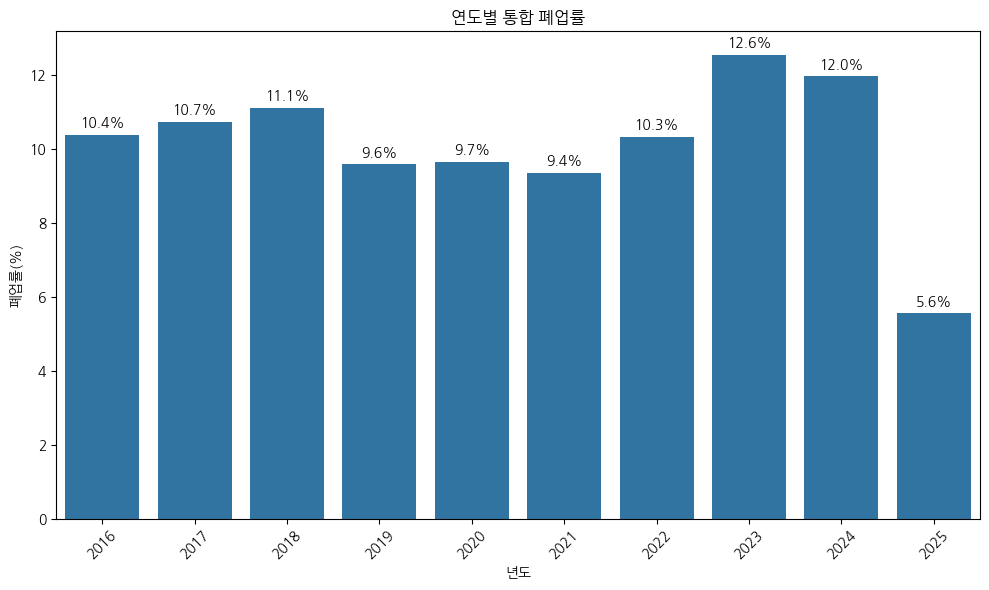

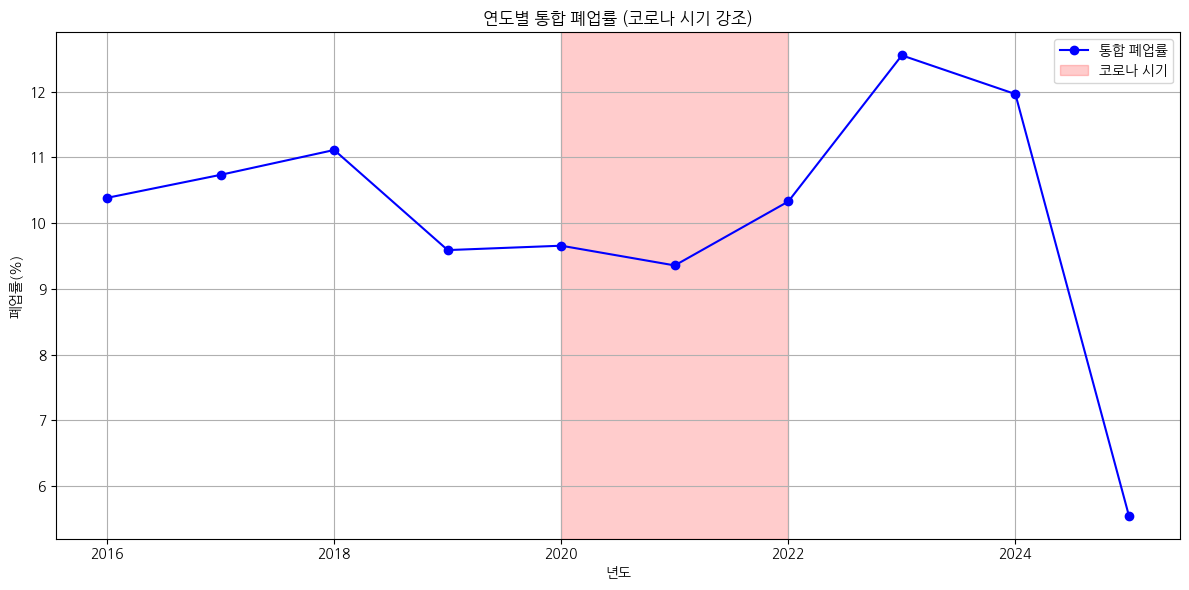

In [42]:
# 구분이 '통합'인 데이터만 필터링
yearly = result_df.groupby('년도')['폐업률(%)'].mean().reset_index()

# 통합 폐업률 막대 그래프
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=yearly, x='년도', y='폐업률(%)', color='#1f77b4', ci=None)

# 각 막대 위에 수치 표기
for p in barplot.patches:
    height = p.get_height()
    barplot.text(p.get_x() + p.get_width() / 2, height + 0.2, f'{height:.1f}%', ha='center')

plt.title('연도별 통합 폐업률')
plt.xlabel('년도')
plt.ylabel('폐업률(%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 라인 그래프
plt.figure(figsize=(12, 6))
plt.plot(yearly['년도'], yearly['폐업률(%)'], marker='o', color='b', label='통합 폐업률')
plt.axvspan(2020, 2022, color='red', alpha=0.2, label='코로나 시기')
plt.title('연도별 통합 폐업률 (코로나 시기 강조)')
plt.xlabel('년도')
plt.ylabel('폐업률(%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipython-input-447163778.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bar = sns.barplot(


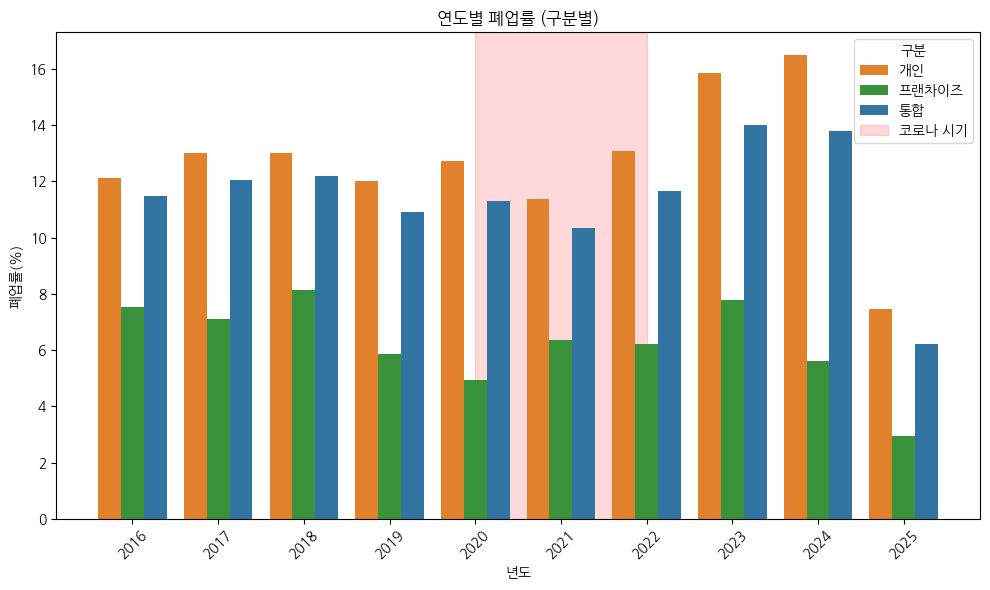

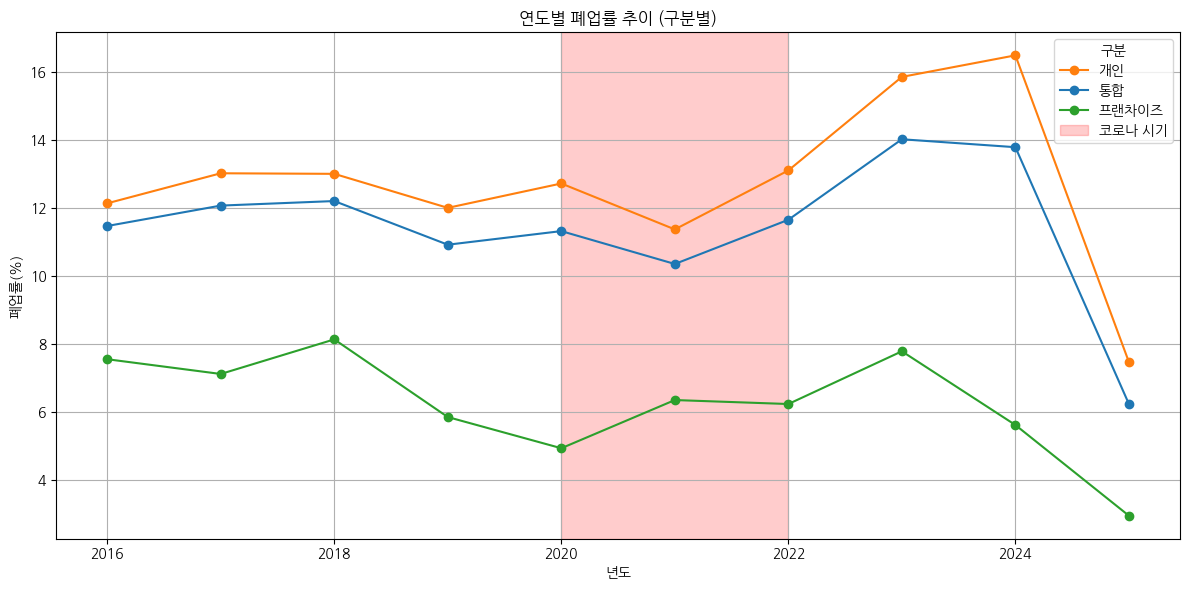

In [43]:
colors = {
    '통합': '#1f77b4',
    '개인': '#ff7f0e',
    '프랜차이즈': '#2ca02c'
}

# ▶️ 그룹드 바 차트(막대그래프)
result_df['년도'] = result_df['년도'].astype(int)

plt.figure(figsize=(10, 6))
bar = sns.barplot(
    data=result_df,
    x='년도',
    y='폐업률(%)',
    hue='구분',
    palette=colors,
    ci=None,
    hue_order=['개인', '프랜차이즈', '통합']
)

# x축 연도 레이블(카테고리)의 위치를 직접 조회
labels = bar.get_xticklabels()
label_text = [int(lbl.get_text()) for lbl in labels]
covid_years = [2020, 2021, 2022]
covid_x = [label_text.index(year) for year in covid_years if year in label_text]

if covid_x:
    # 인덱스 기준: (ex) 2020~2022 중심에 음영
    start, end = min(covid_x), max(covid_x)
    plt.axvspan(start, end, color='red', alpha=0.15, zorder=0, label='코로나 시기')

plt.title('연도별 폐업률 (구분별)')
plt.xlabel('년도')
plt.ylabel('폐업률(%)')
plt.xticks(rotation=45)
plt.legend(title='구분')
plt.tight_layout()
plt.show()

# ▶️ 멀티라인 차트
mean_by_year_category = result_df.groupby(['년도', '구분'])['폐업률(%)'].mean().reset_index()

plt.figure(figsize=(12, 6))
for category in mean_by_year_category['구분'].unique():
    subset = mean_by_year_category[mean_by_year_category['구분'] == category]
    plt.plot(subset['년도'], subset['폐업률(%)'], marker='o', label=category, color=colors.get(category, None))

plt.axvspan(2020, 2022, color='red', alpha=0.2, label='코로나 시기')
plt.title('연도별 폐업률 추이 (구분별)')
plt.xlabel('년도')
plt.ylabel('폐업률(%)')
plt.legend(title='구분')
plt.grid(True)
plt.tight_layout()
plt.show()

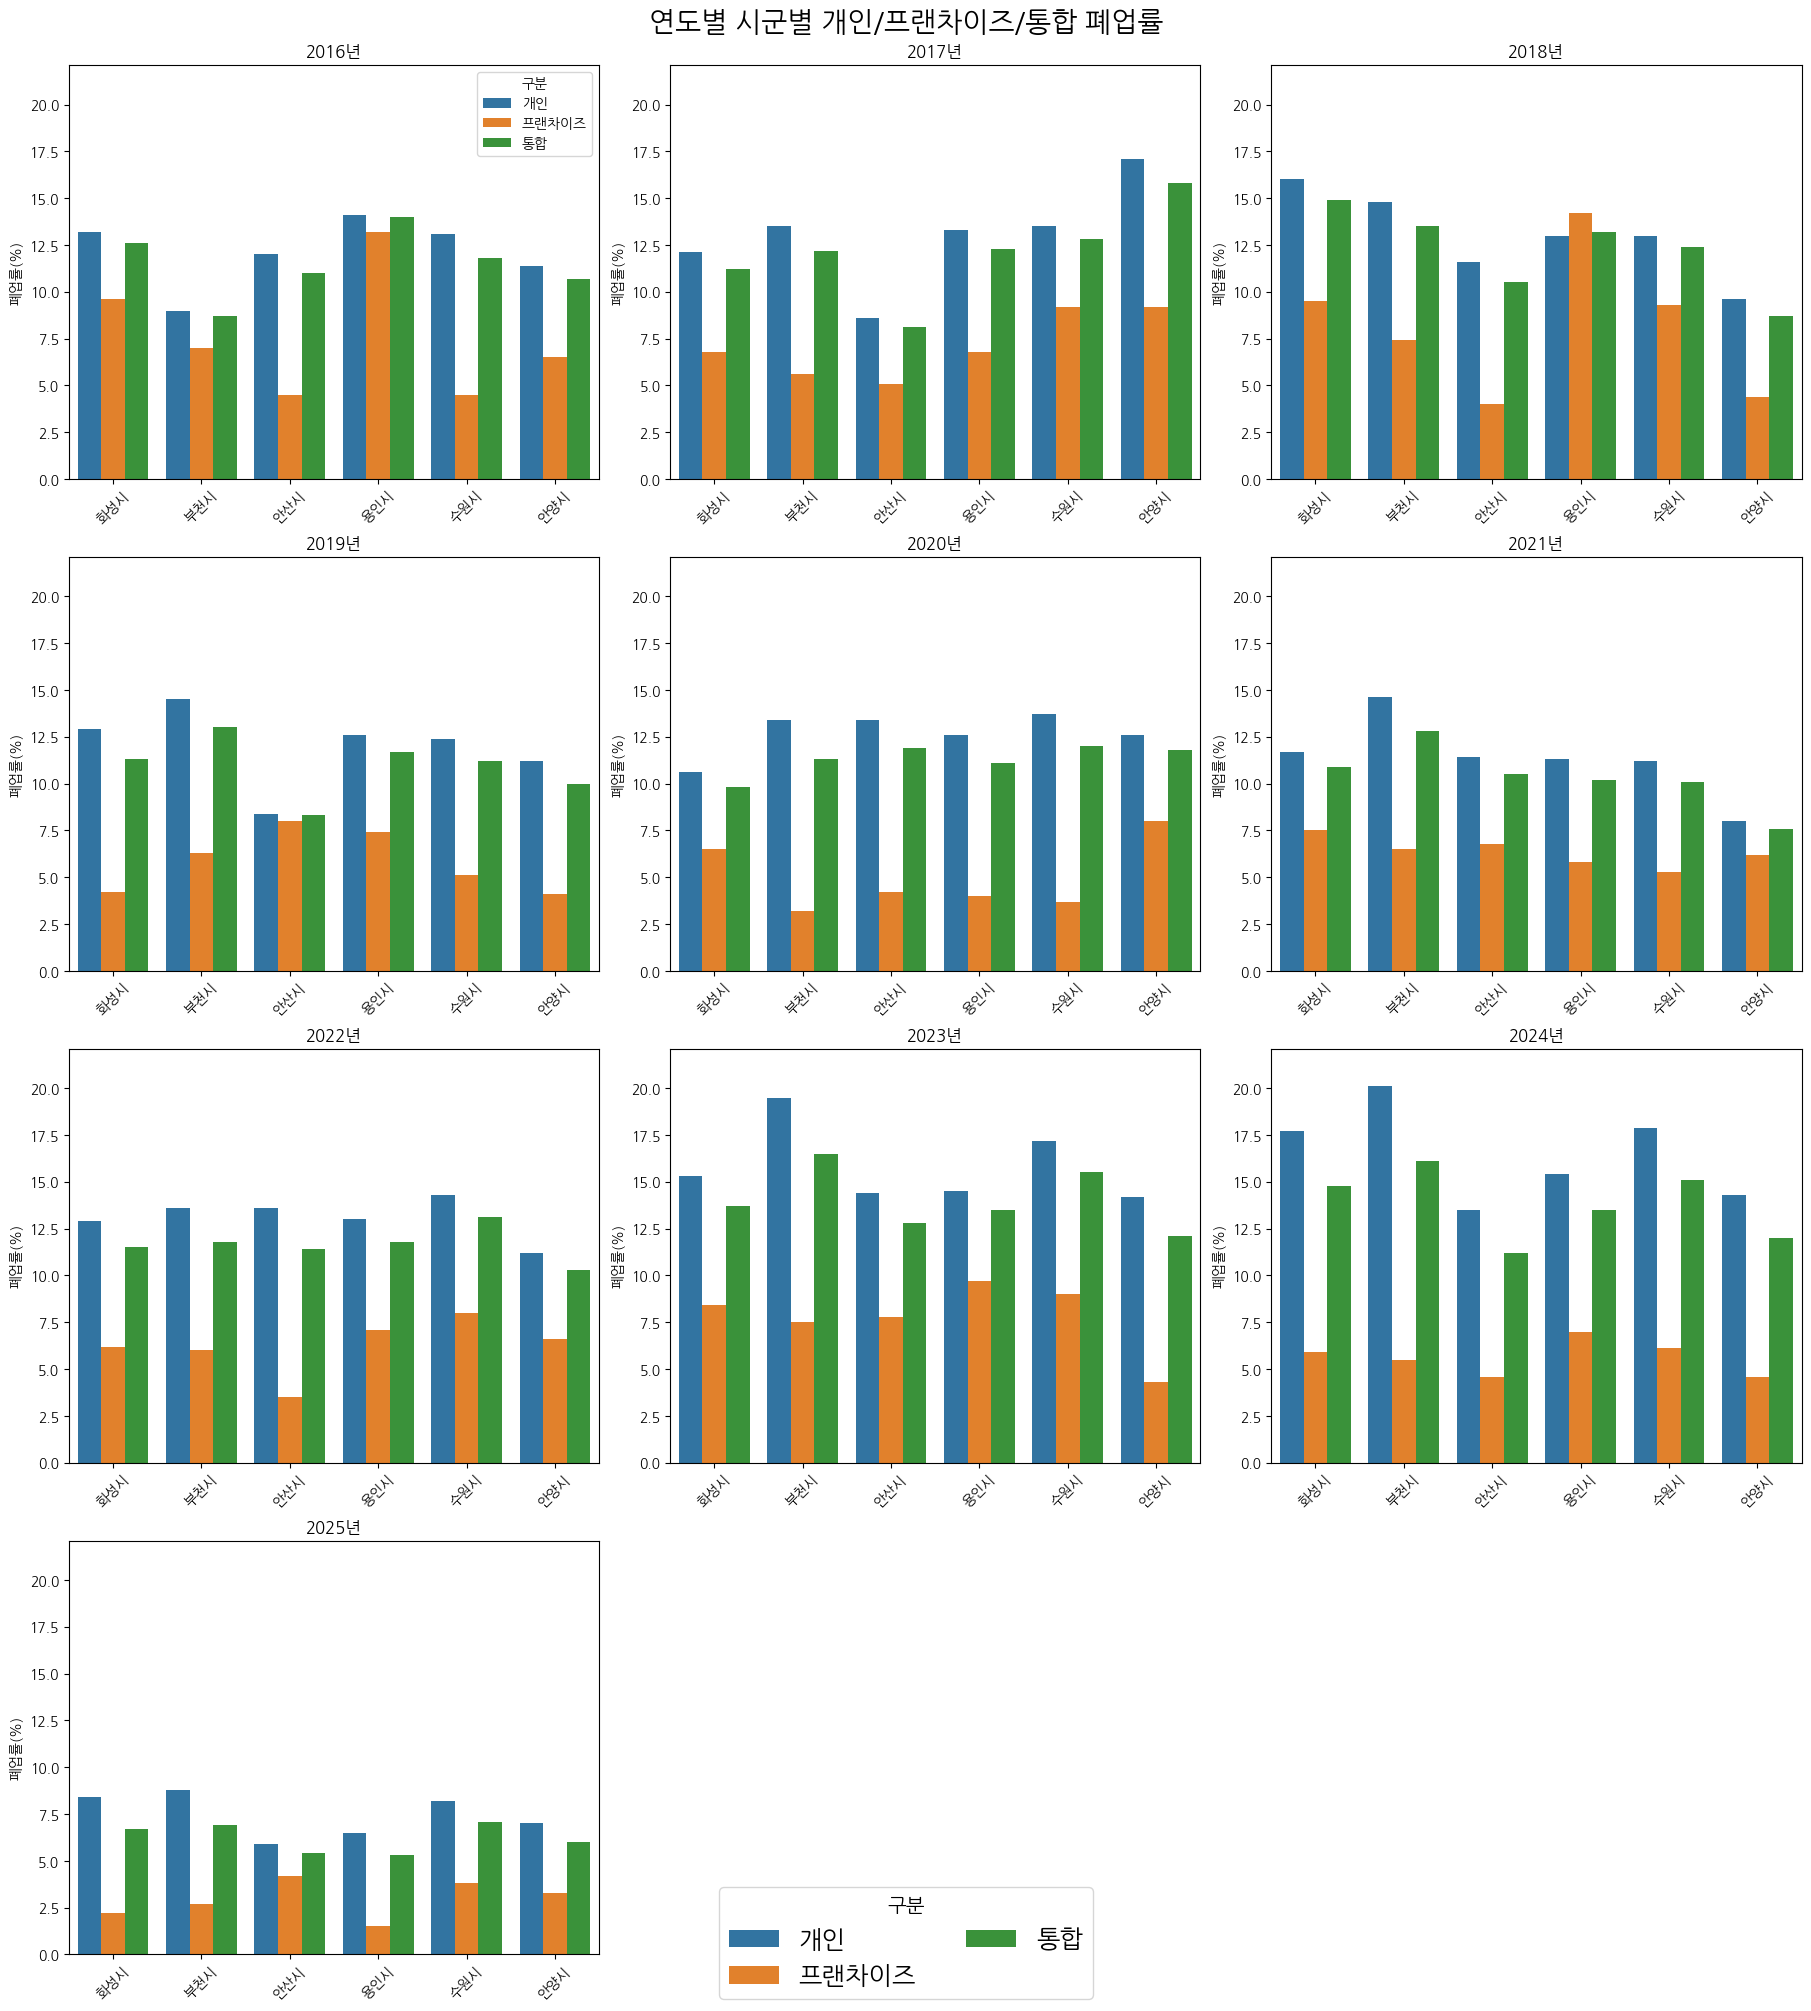

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

num_years = len(year_range)
cols = 3  # 한 행에 들어갈 subplot 수
rows = math.ceil(num_years / cols)

y_max = result_df['폐업률(%)'].max() * 1.1

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 5*rows), constrained_layout=True)
axes = axes.flatten()

custom_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

fig.suptitle('연도별 시군별 개인/프랜차이즈/통합 폐업률', fontsize=20)

for i, year in enumerate(year_range):
    ax = axes[i]
    data_subset = result_df[result_df['년도'] == year]
    sns.barplot(data=data_subset, x='시군명', y='폐업률(%)', hue='구분', palette=custom_colors, ax=ax)
    ax.set_title(f'{year}년')
    ax.set_xlabel('')
    ax.set_ylim(0, y_max)
    ax.set_ylabel('폐업률(%)')
    ax.tick_params(axis='x', rotation=45)
    if i != 0:
      ax.get_legend().remove()

# 여분 subplot 숨기기
for i in range(num_years, len(axes)):
    fig.delaxes(axes[i])

# 큰 legend를 마지막 row 아래 여러 그래프에 공통 적용
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=18, title="구분", title_fontsize="x-large")

plt.show()

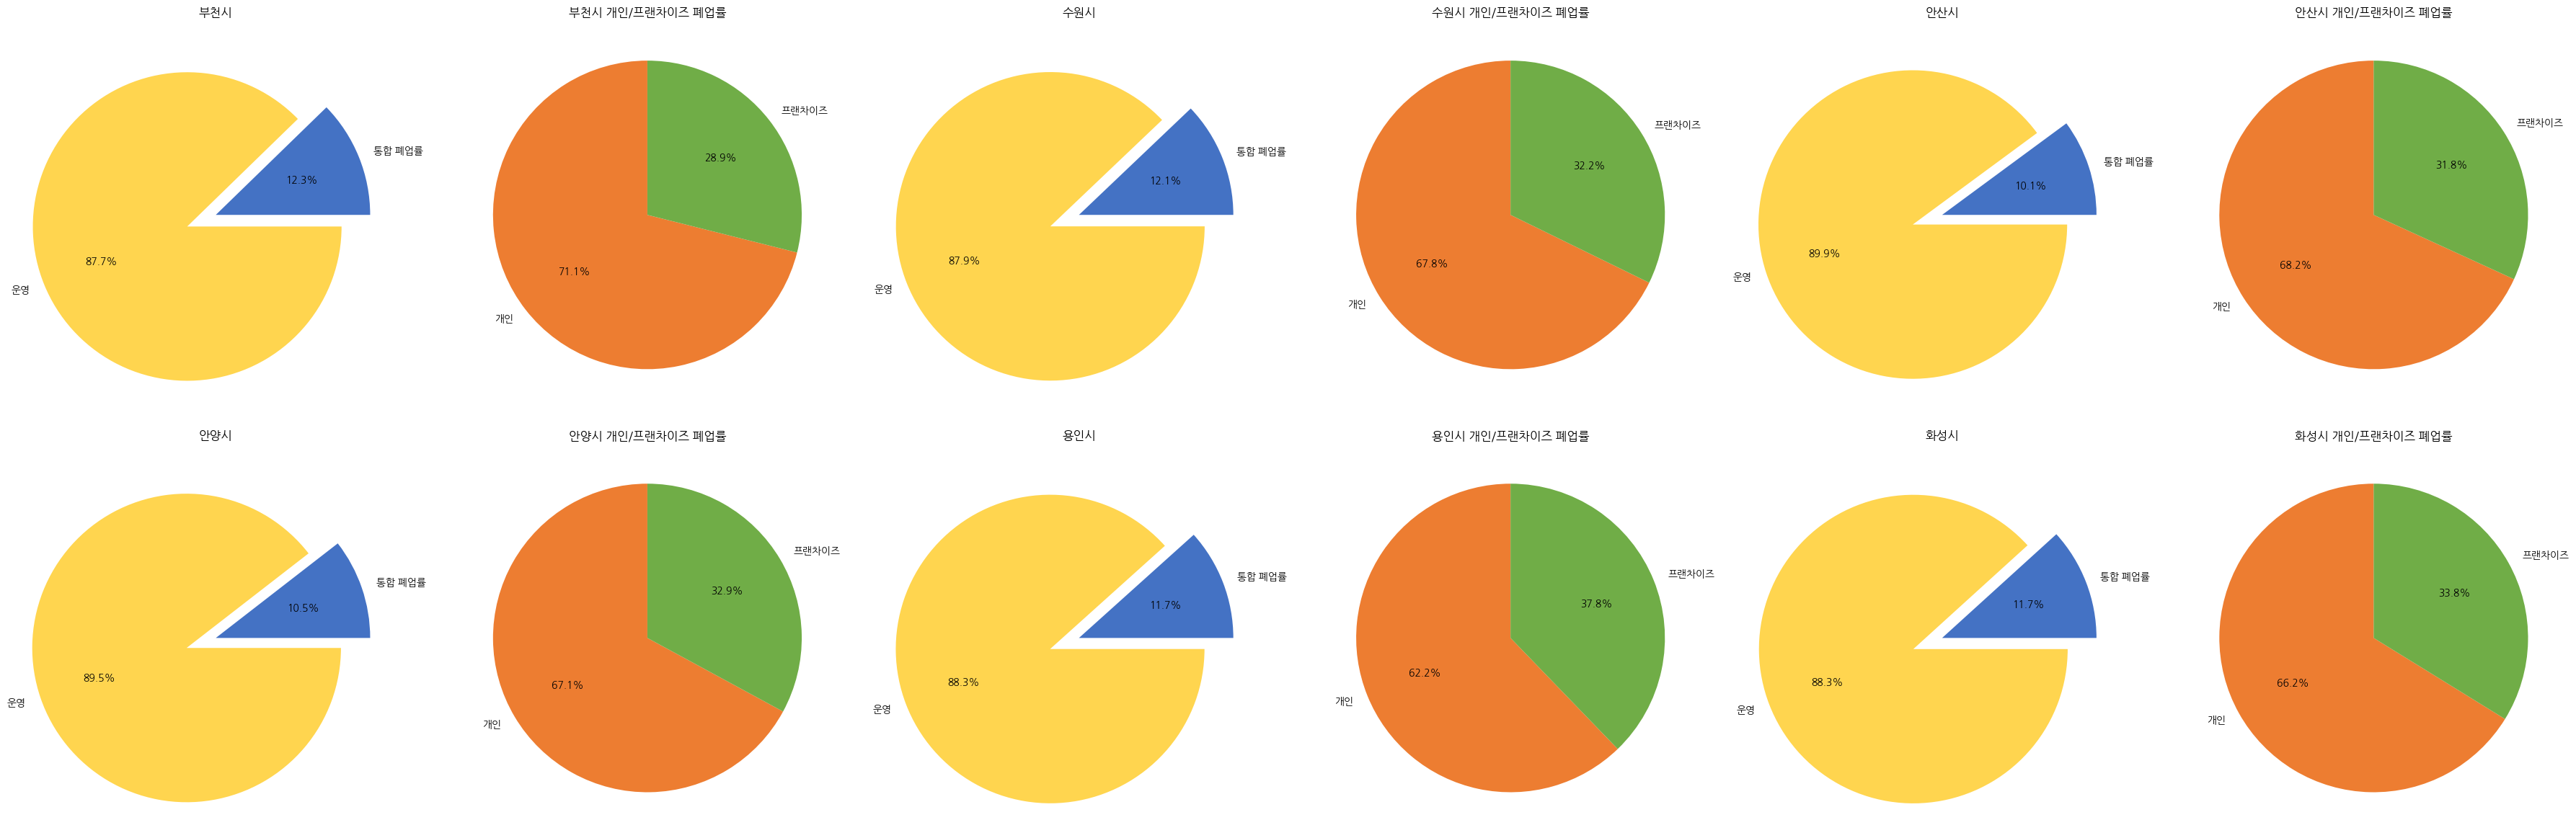

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

pivot_df = result_df.groupby(['시군명', '구분'])['폐업률(%)'].mean().unstack()

num_cities = len(pivot_df)

cols = 3
rows = 2
fig, axes = plt.subplots(rows, cols * 2, figsize=(6 * cols * 2, 6 * rows))
axes = axes.flatten()

# fig.suptitle("시군별 통합/개인/프랜차이즈 폐업률", fontsize=20)

for i, city in enumerate(pivot_df.index):
    row = i // cols
    col = i % cols
    idx = row * cols * 2 + col * 2

    axes[idx].set_title(f'{city}')

    # 통합 폐업률 vs 운영(나머지)
    integrated = pivot_df.loc[city, '통합']
    other = 100 - integrated
    axes[2*i].pie([integrated, other], labels=[f'통합 폐업률', '운영'], explode=(0, 0.2), colors=['#4472c4', '#ffd54f'], autopct='%1.1f%%', startangle=0)
    axes[2*i].set_title(f'{city}')

    # 통합 폐업률 안에서 개인/프랜차이즈 비율 (통합=100%)
    personal = pivot_df.loc[city, '개인']
    franchise = pivot_df.loc[city, '프랜차이즈']
    total = personal + franchise

    if total == 0:
        personal_ratio = franchise_ratio = 0
    else:
        personal_ratio = personal / total * integrated  # 통합 중에서 개인이 차지하는 실제 값
        franchise_ratio = franchise / total * integrated

    axes[idx + 1].pie(
        [personal_ratio, franchise_ratio],
        labels=['개인', '프랜차이즈'],
        colors=['#ed7d31', '#70ad47'],
        autopct='%1.1f%%',
        startangle=90
    )
    axes[idx + 1].set_title(f'{city} 개인/프랜차이즈 폐업률')

# 빈 subplot 제거
for j in range(len(pivot_df) * 2, rows * cols * 2):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


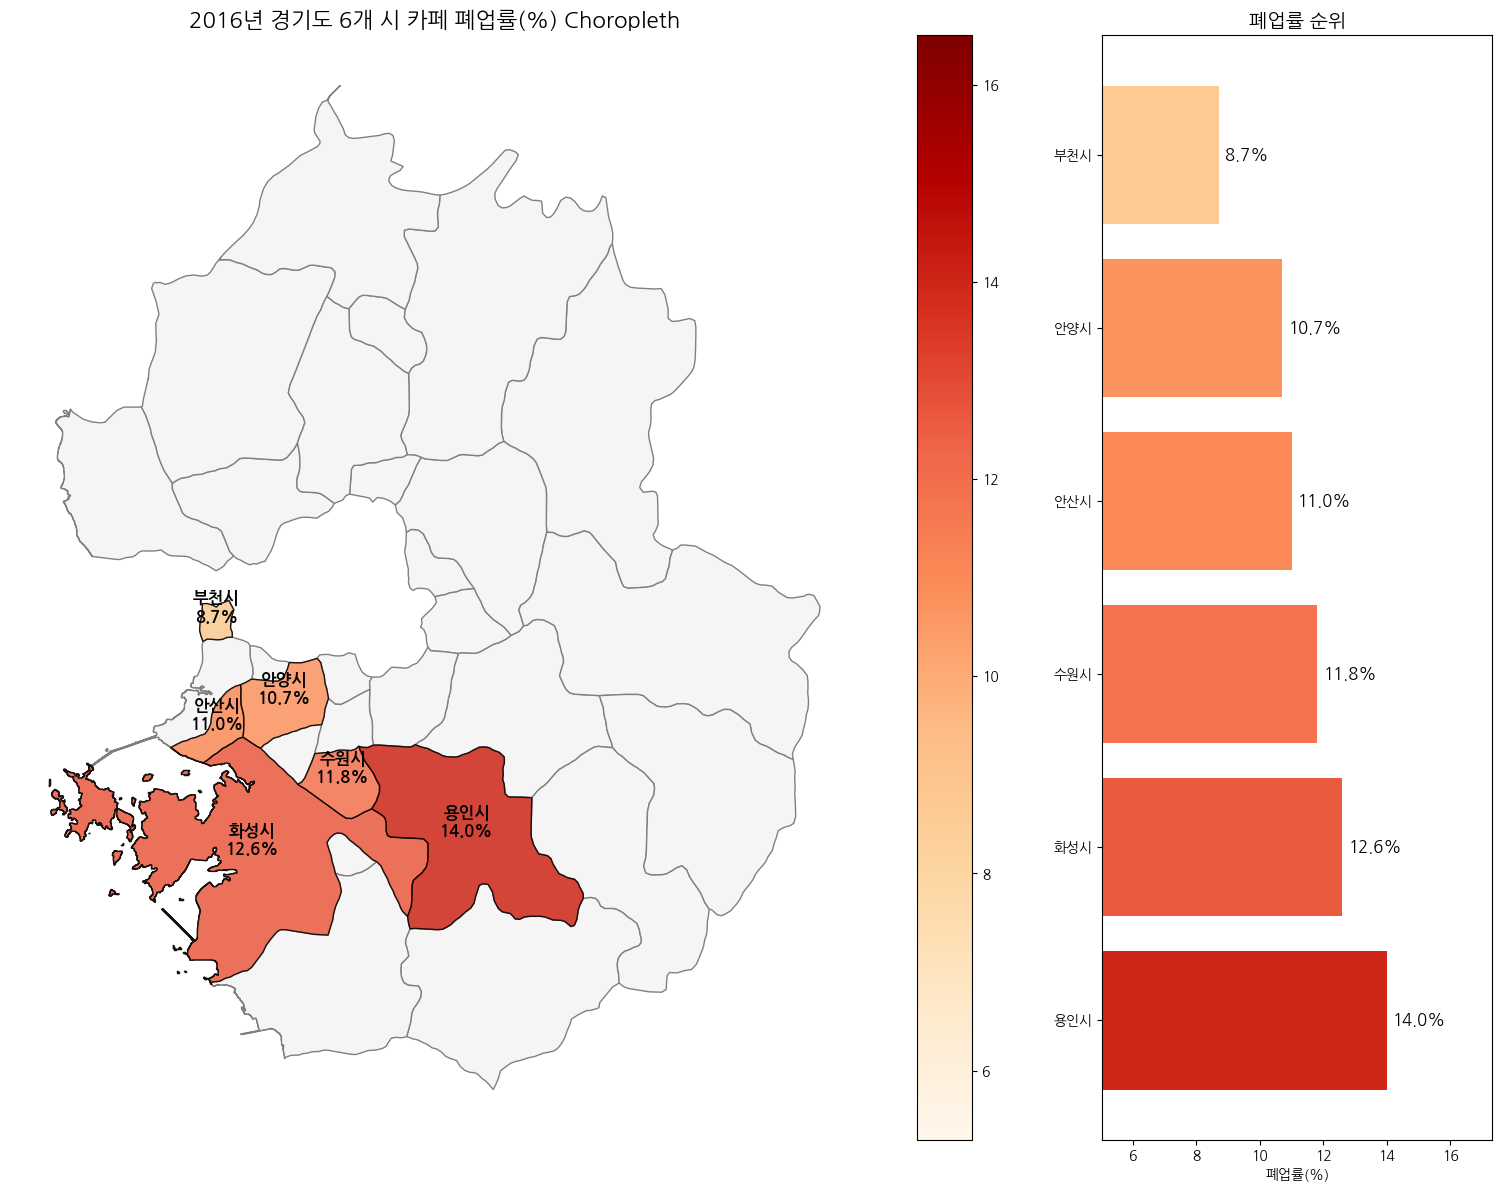

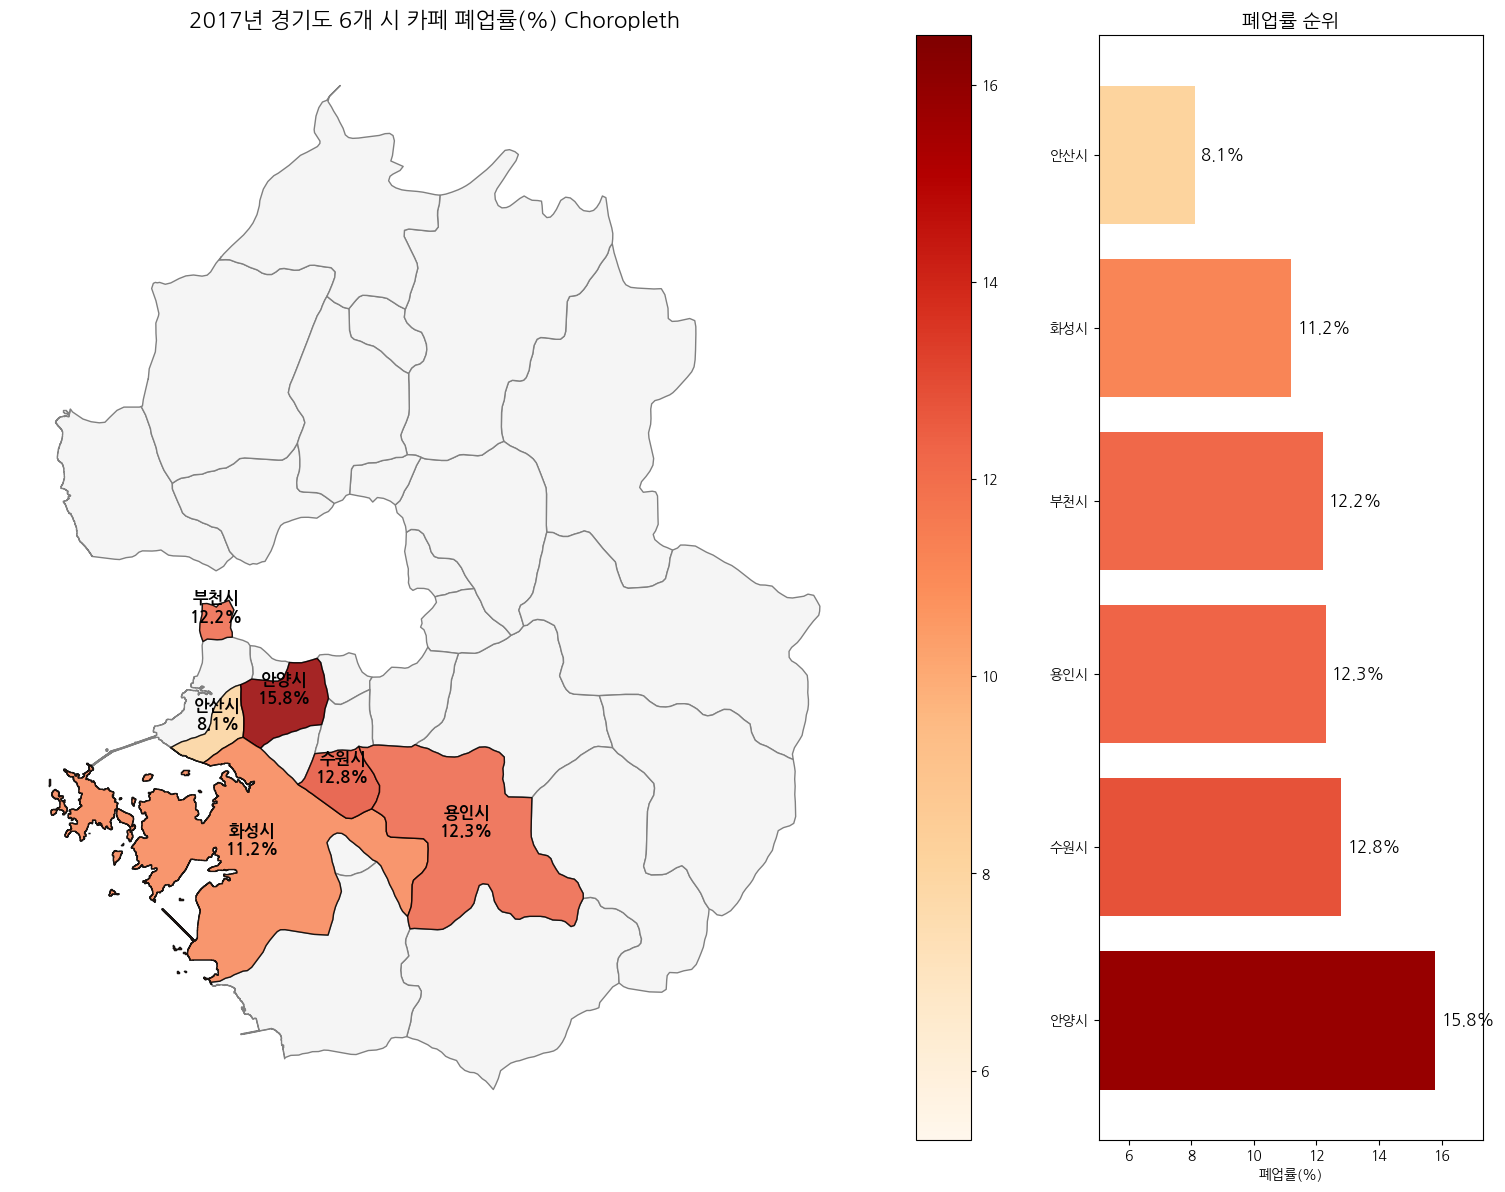

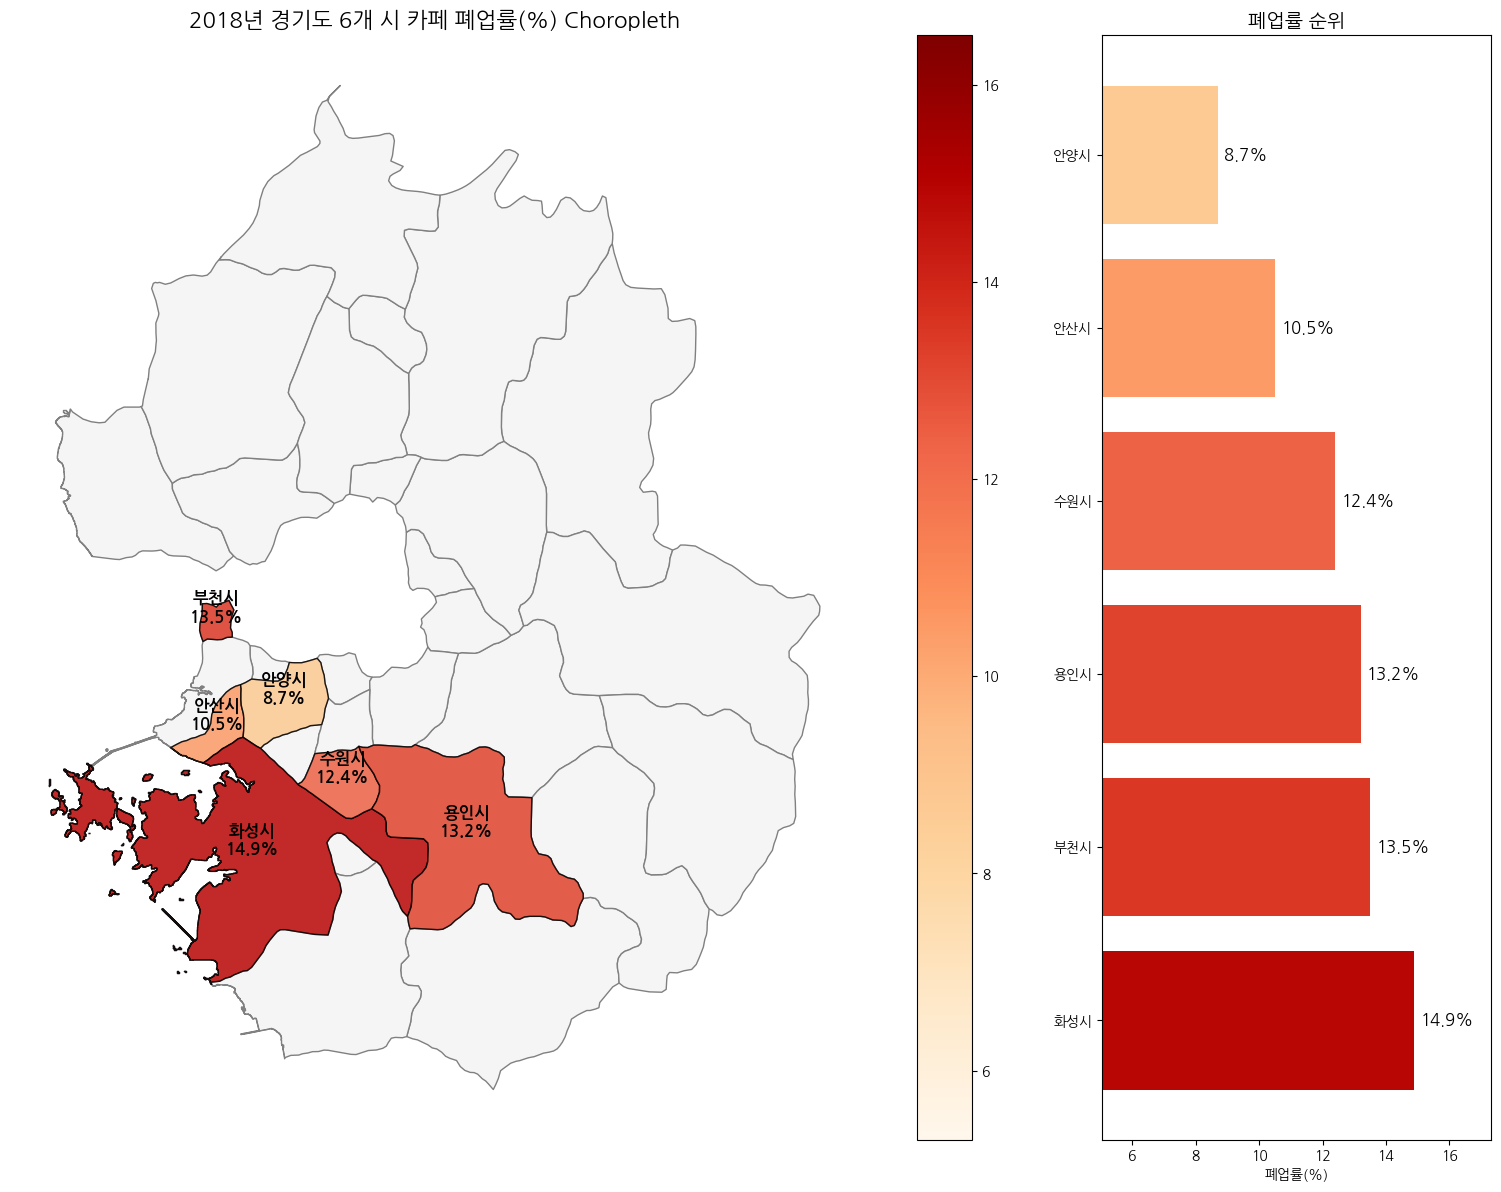

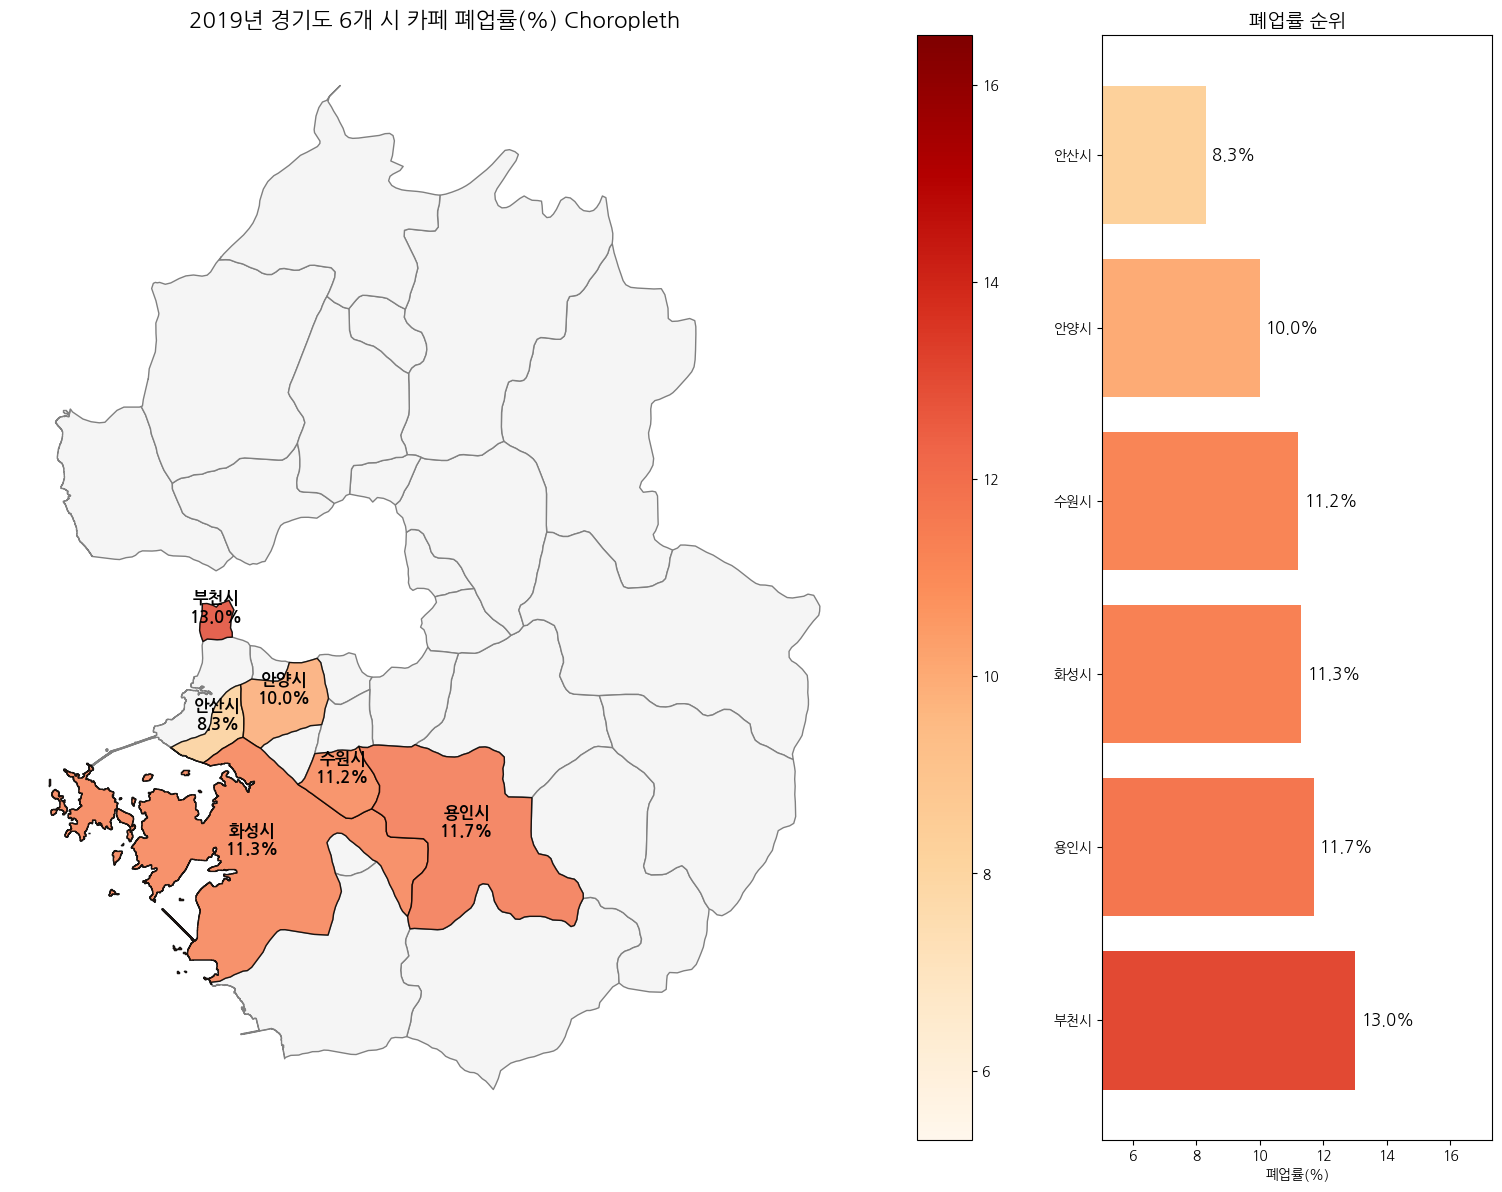

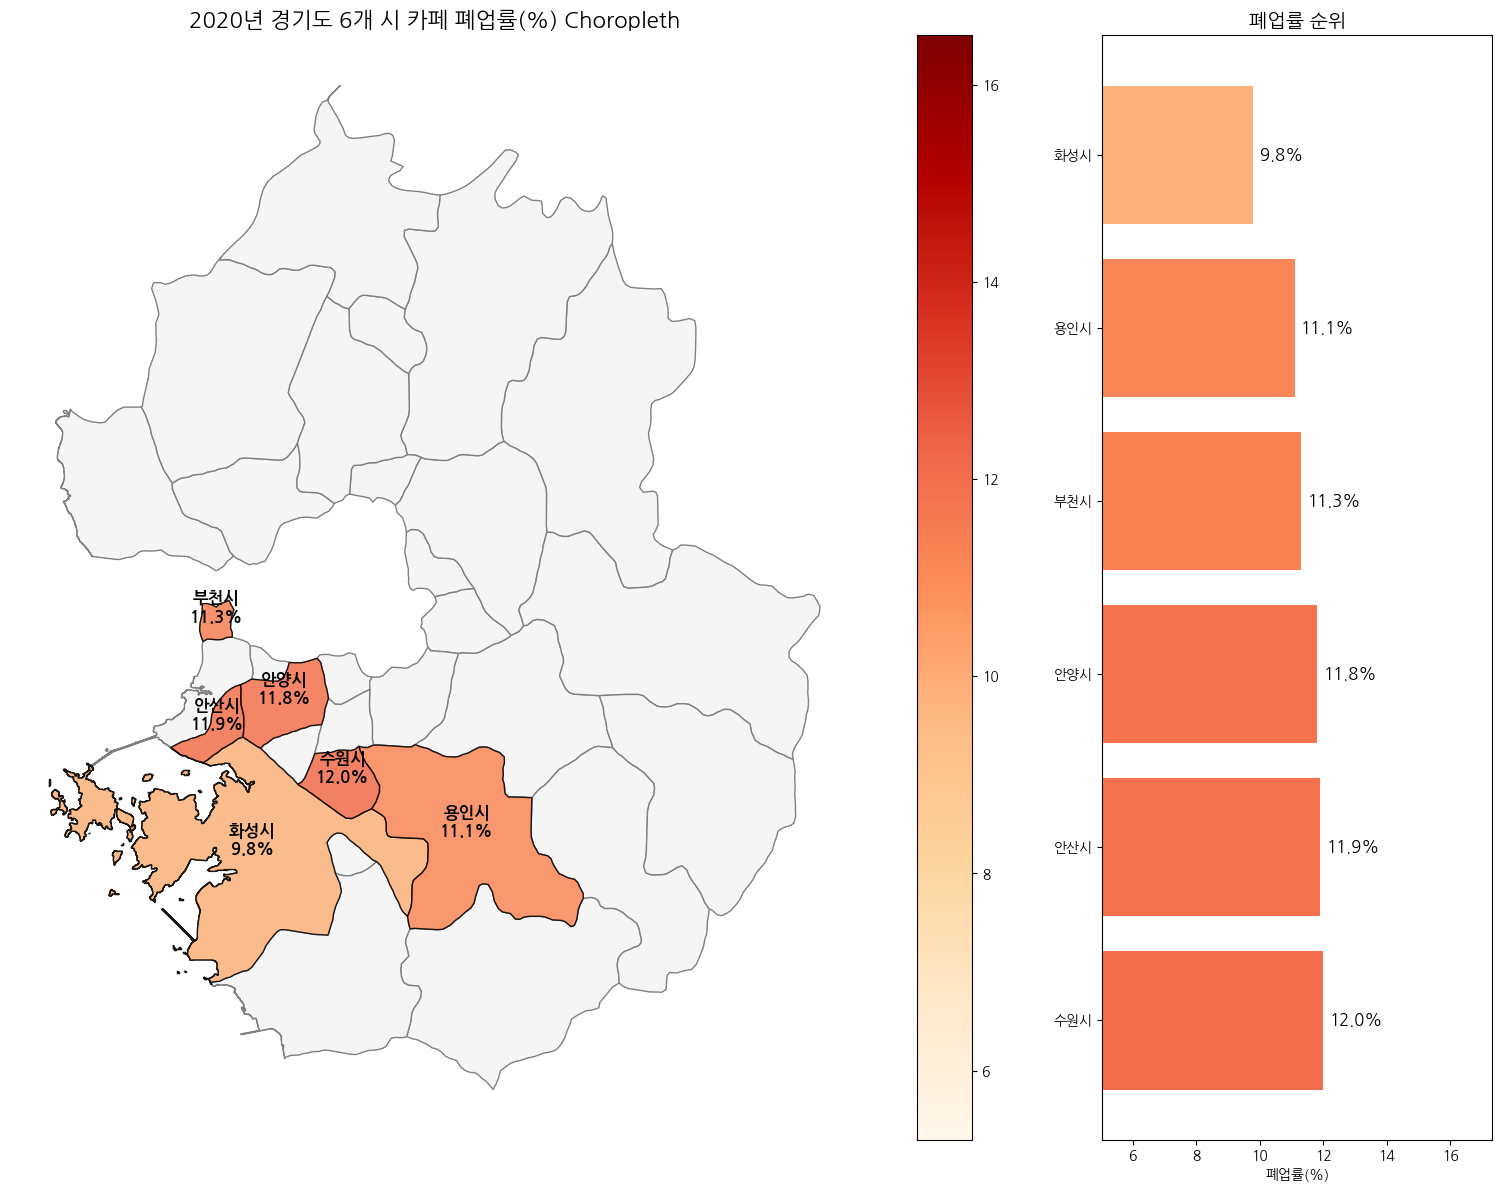

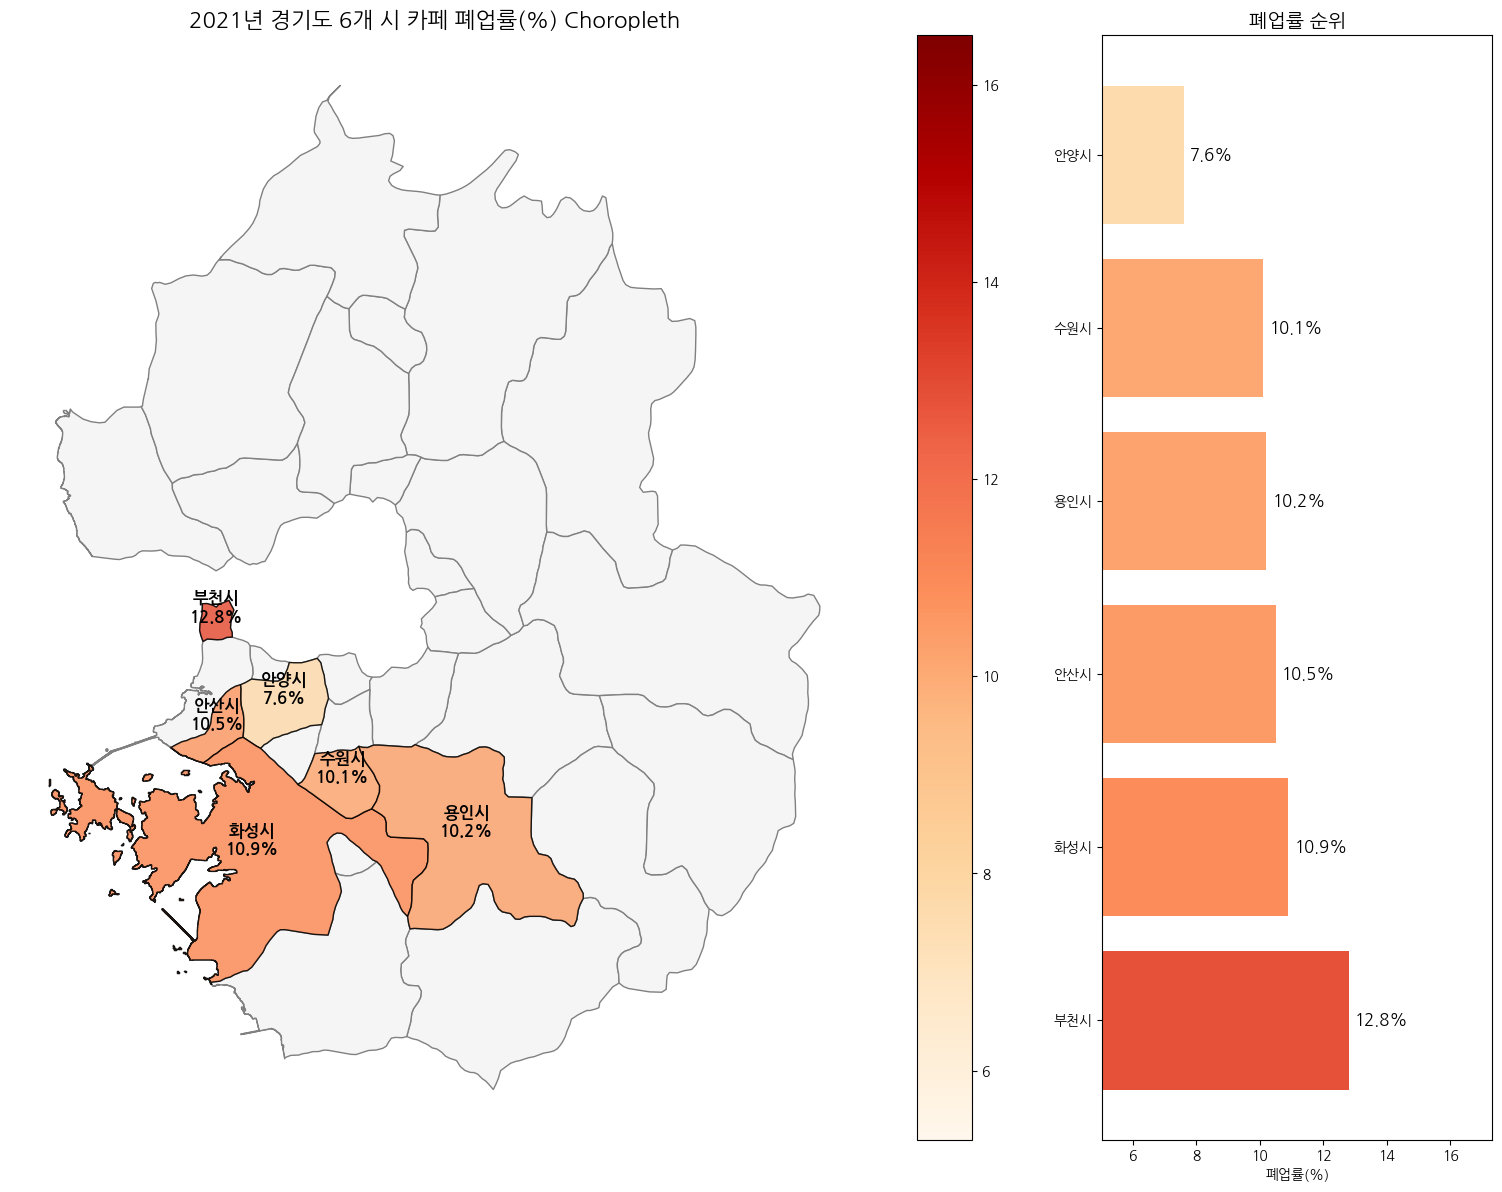

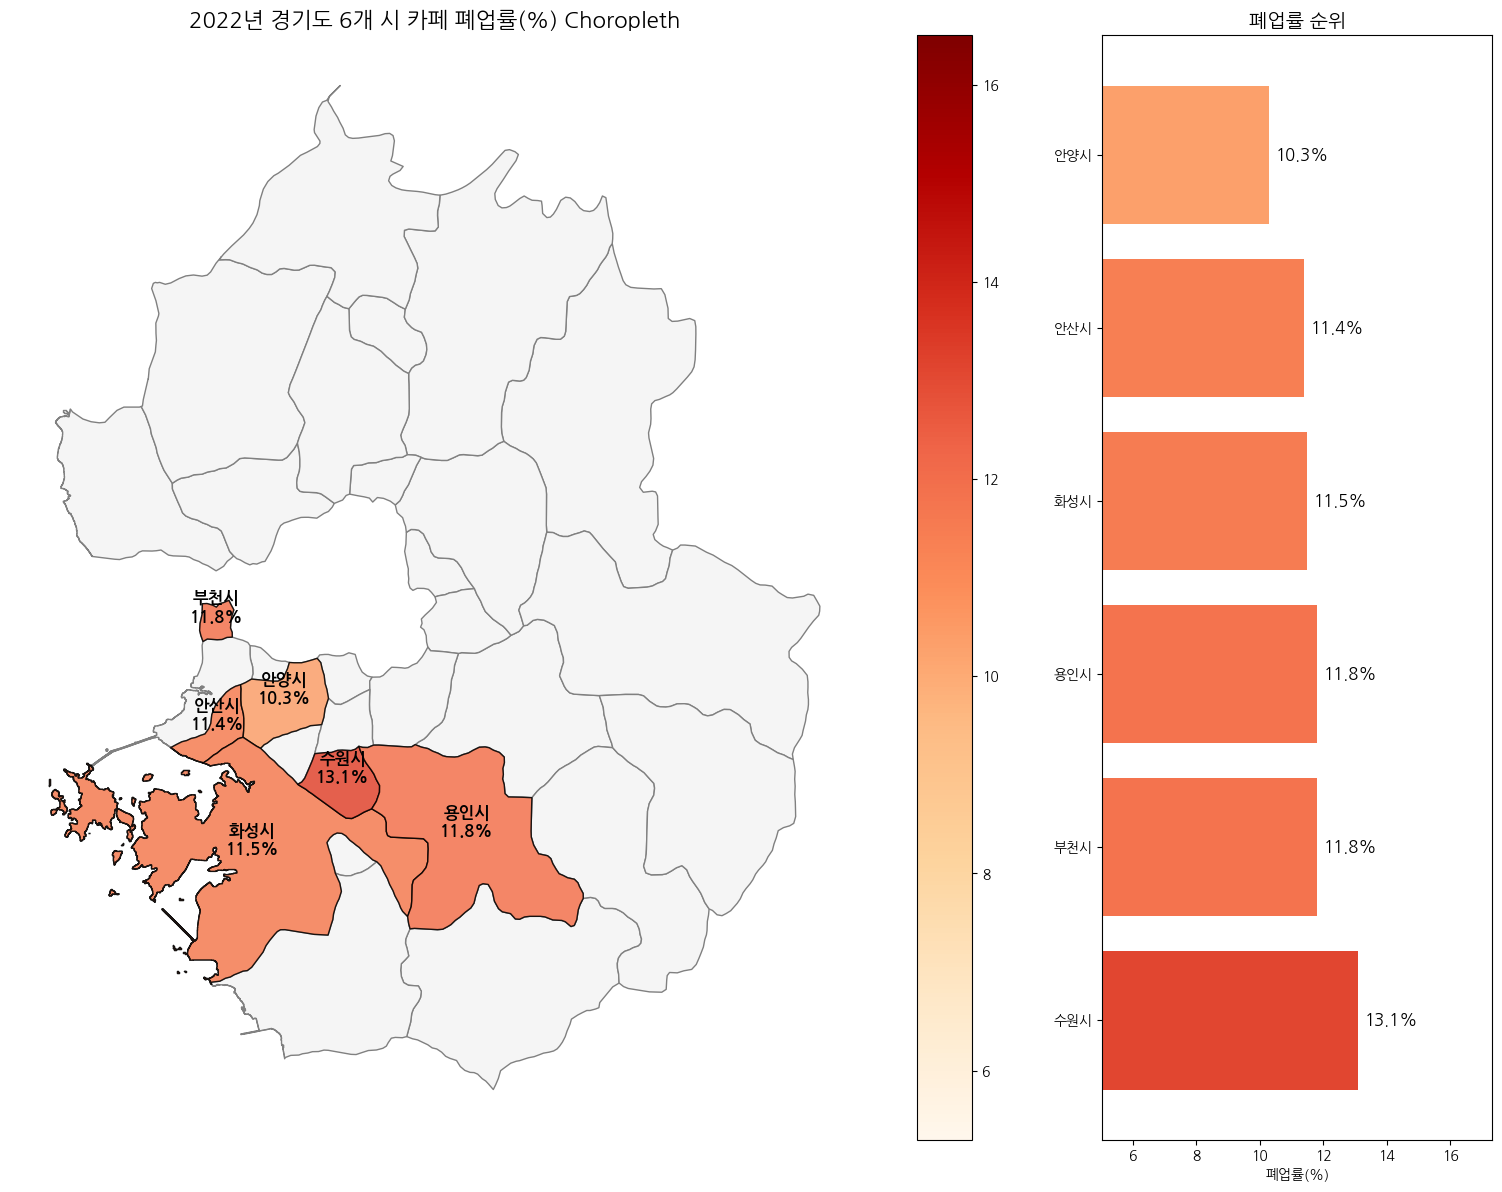

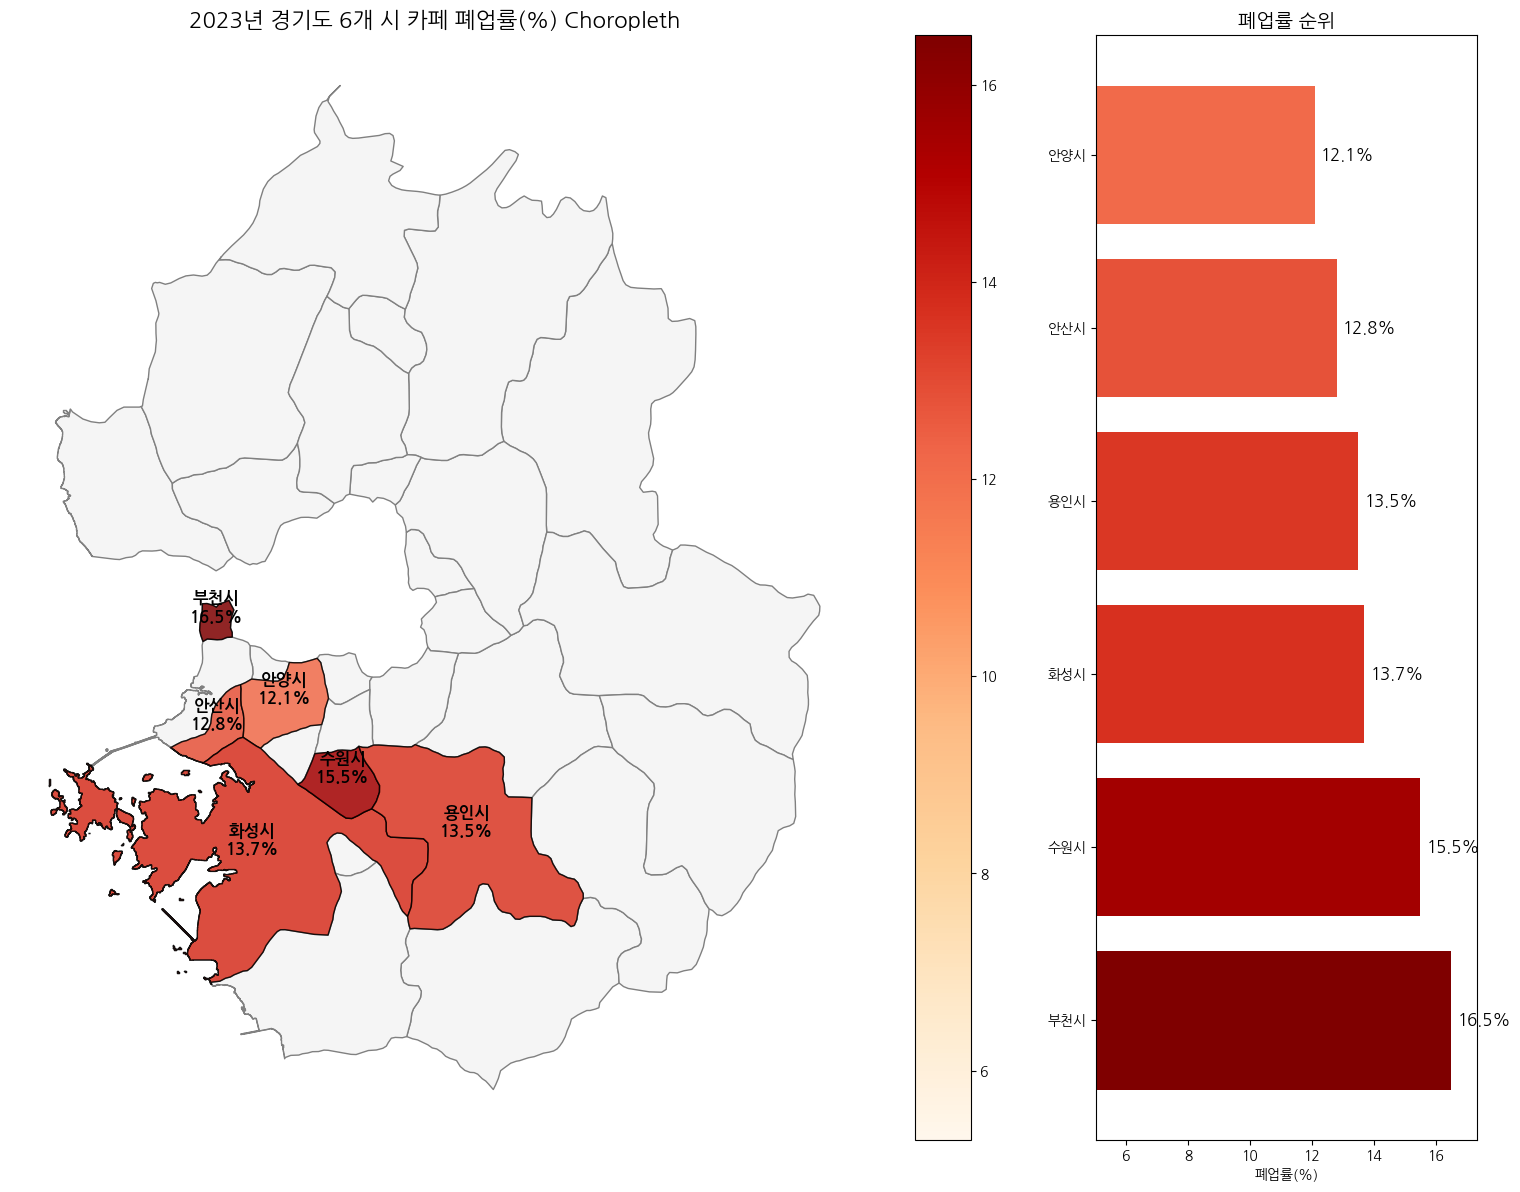

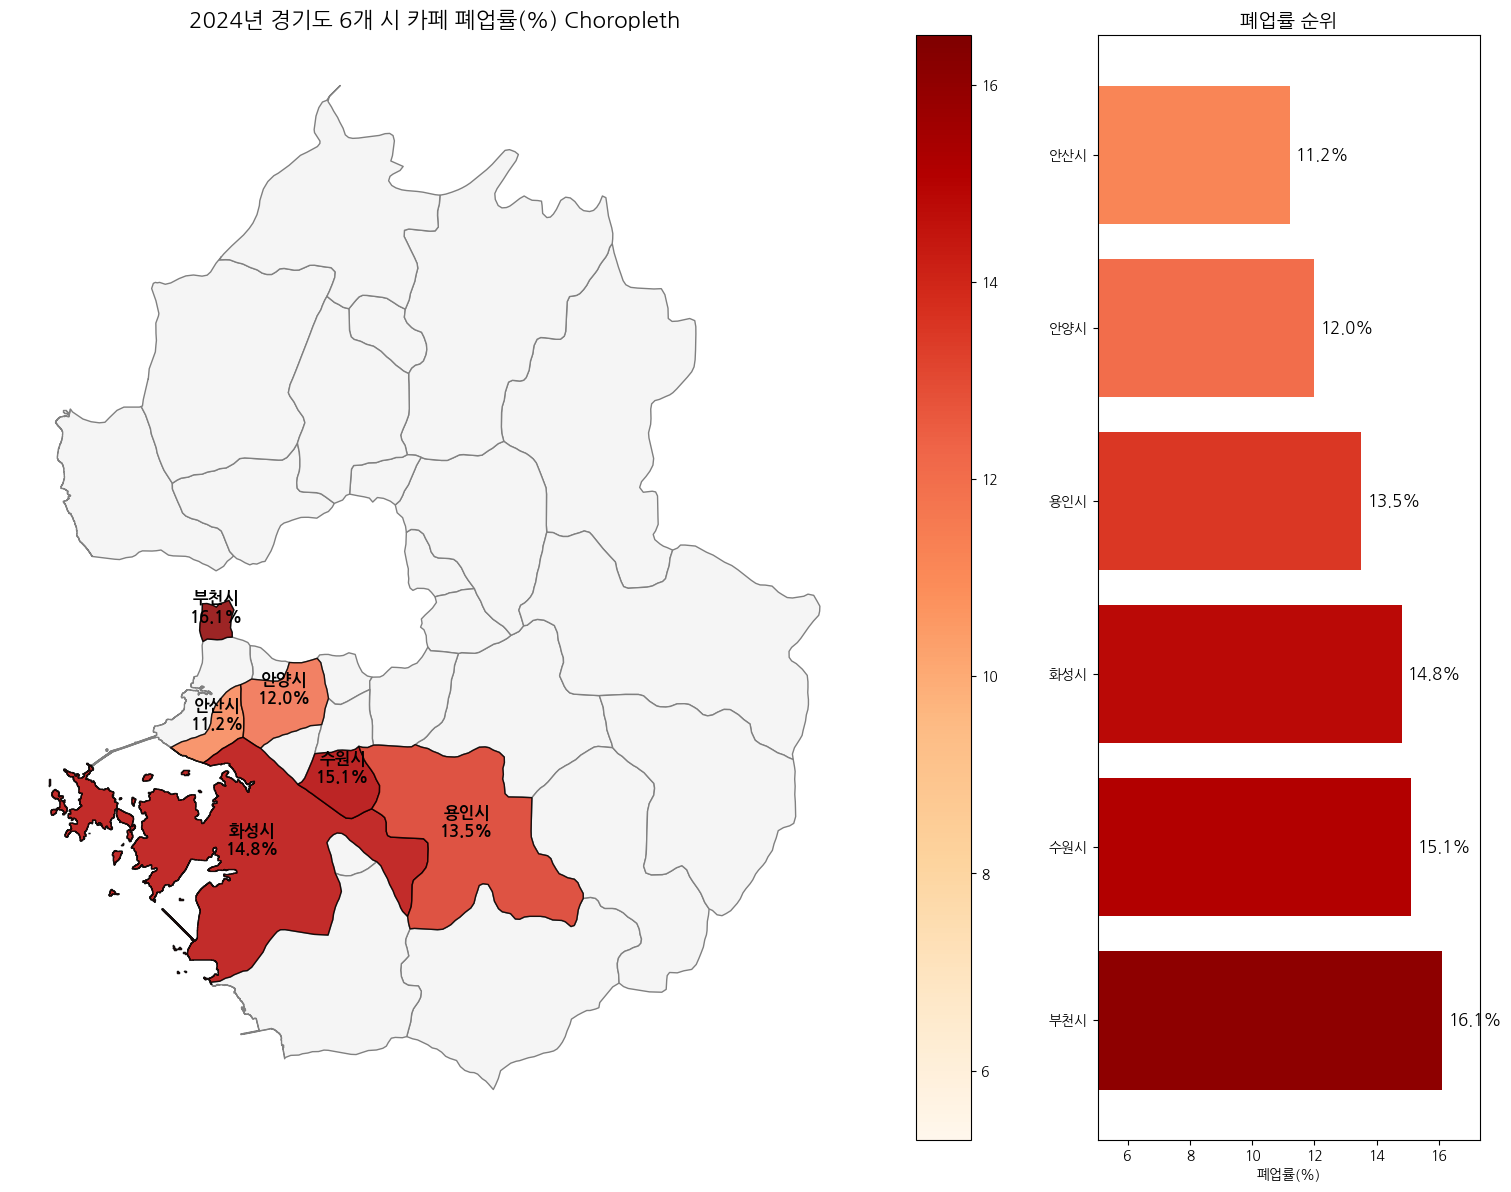

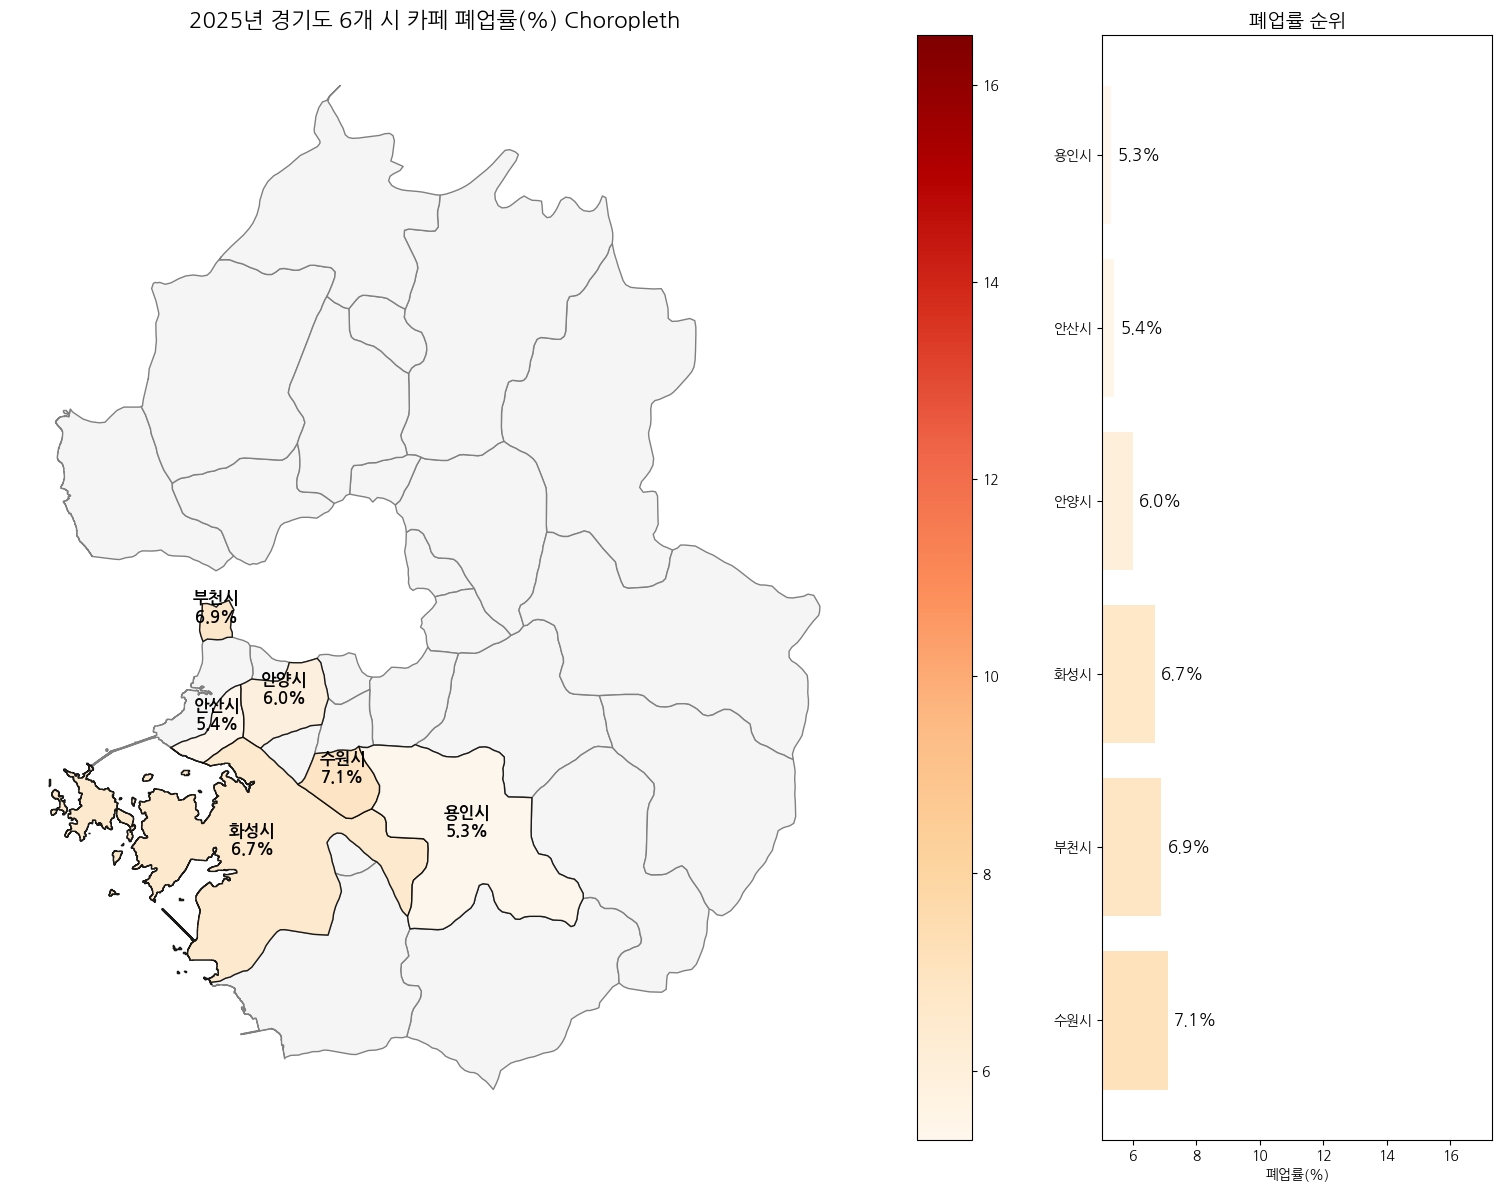

In [46]:
# 코로플레스 맵
import geopandas as gpd
from shapely.geometry import Polygon

korean_to_english = {
    '부천시': 'Bucheon',
    '수원시': 'Suwon',
    '안산시': 'Ansan',
    '안양시': 'Anyang',
    '화성시': 'Hwaseong',
    '용인시': 'Yongin',
}

df = result_df.copy()
df = df[df['구분'] == '통합']
df['NAME_2'] = df['시군명'].map(korean_to_english)

file_path = "https://raw.githubusercontent.com/southkorea/southkorea-maps/master/gadm/json/skorea-municipalities-geo.json"
geo_gdf = gpd.read_file(file_path)

target_cities = list(korean_to_english.values())
gyeonggi_gdf = geo_gdf[geo_gdf['NAME_1'] == 'Gyeonggi-do']
highlight_gdf = geo_gdf[geo_gdf['NAME_2'].isin(target_cities)]

# 4. 년도별 Choropleth 반복 그리기
years = sorted(df['년도'].unique())

for year in years:
    dyear = df[df['년도'] == year]
    merged = highlight_gdf.merge(dyear, on='NAME_2', how='left')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 12), gridspec_kw={'width_ratios':[3,1]})

    # 1. 지도 (왼쪽 패널)
    gyeonggi_gdf.plot(ax=ax1, color='whitesmoke', edgecolor='grey')
    merged.plot(
        column='폐업률(%)',
        cmap='OrRd',
        legend=True,
        edgecolor='black',
        ax=ax1,
        alpha=0.85,
        vmin=df['폐업률(%)'].min(),
        vmax=df['폐업률(%)'].max(),
        missing_kwds={'color': 'lightgrey'}
    )
    for idx, row in merged.iterrows():
        if row['geometry'].is_empty or pd.isna(row['폐업률(%)']):
            continue
        x, y = row['geometry'].centroid.coords[0]
        label = f"{row['시군명']}\n{row['폐업률(%)']}%"
        ax1.annotate(label, (x, y), ha='center', fontsize=12, color='black', weight='bold')
    ax1.set_title(f"{year}년 경기도 6개 시 카페 폐업률(%) Choropleth", fontsize=16)
    ax1.axis('off')

    # 2. 바 차트 (오른쪽 패널, 지도와 수치 동일)
    # 폐업률 기준 내림차순 정렬
    bar_data = dyear.sort_values('폐업률(%)', ascending=False)
    bars = ax2.barh(bar_data['시군명'], bar_data['폐업률(%)'], color=plt.cm.OrRd(
        (bar_data['폐업률(%)'] - df['폐업률(%)'].min())/(df['폐업률(%)'].max()-df['폐업률(%)'].min())
    ))
    ax2.set_xlim(df['폐업률(%)'].min()*0.95, df['폐업률(%)'].max()*1.05)
    ax2.set_xlabel('폐업률(%)')
    ax2.set_title('폐업률 순위', fontsize=14)
    for i, v in enumerate(bar_data['폐업률(%)']):
        ax2.text(v+0.2, i, f"{v}%", va='center', fontsize=12)

    plt.tight_layout()
    plt.show()

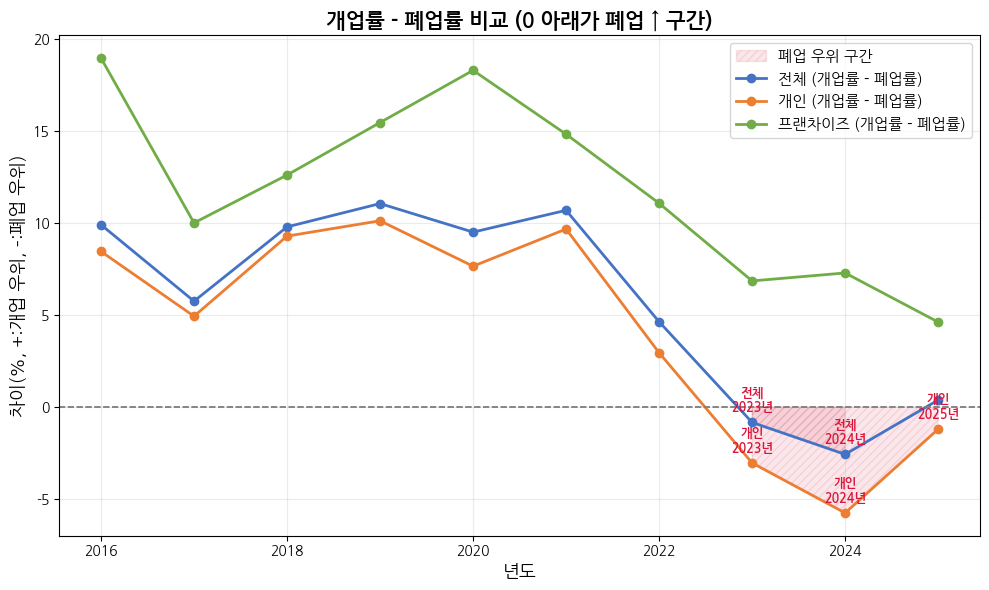

In [47]:
# 개업률, 폐업률 그래프
plt.figure(figsize=(10,6))

label_flag = True

for key, label, color in [('통합','전체','#4472c4'), ('개인','개인','#ed7d31'), ('프랜차이즈','프랜차이즈','#70ad47')]:
    grp = result_df[result_df['구분']==key].groupby('년도')[['개업률(%)','폐업률(%)']].mean().reset_index()
    grp['차이'] = grp['개업률(%)'] - grp['폐업률(%)']

    # "폐업 우위" 구간 하이라이트(붉은 음영)
    plt.fill_between(grp['년도'], 0, grp['차이'],
                     where=grp['차이']<0, color='crimson', alpha=0.1, label='폐업 우위 구간' if label_flag else None, hatch='////', edgecolor='firebrick')
    label_flag = False

    plt.plot(grp['년도'], grp['차이'], marker='o', linewidth=2, label=f"{label} (개업률－폐업률)", color=color)
    plt.axhline(0, color='gray', linestyle='--', alpha=0.7, linewidth=1.2)  # 기준선
    cross_idx = grp[grp['차이']<0].index
    for i in cross_idx:
        # plt.scatter(grp.loc[i, '년도'], grp.loc[i, '차이'], s=140, color='crimson', edgecolor='black', zorder=10)
        # 교차 연도 표시
        plt.text(grp.loc[i, '년도'], grp.loc[i, '차이']+0.6, f"{label}\n{int(grp.loc[i, '년도'])}년",
                 ha='center', fontsize=9, weight='bold', color='crimson')

plt.title("개업률－폐업률 비교 (0 아래가 폐업 ↑ 구간)", fontsize=15, fontweight='bold')
plt.xlabel("년도", fontsize=13)
plt.ylabel("차이(%, +:개업 우위, –:폐업 우위)", fontsize=13)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

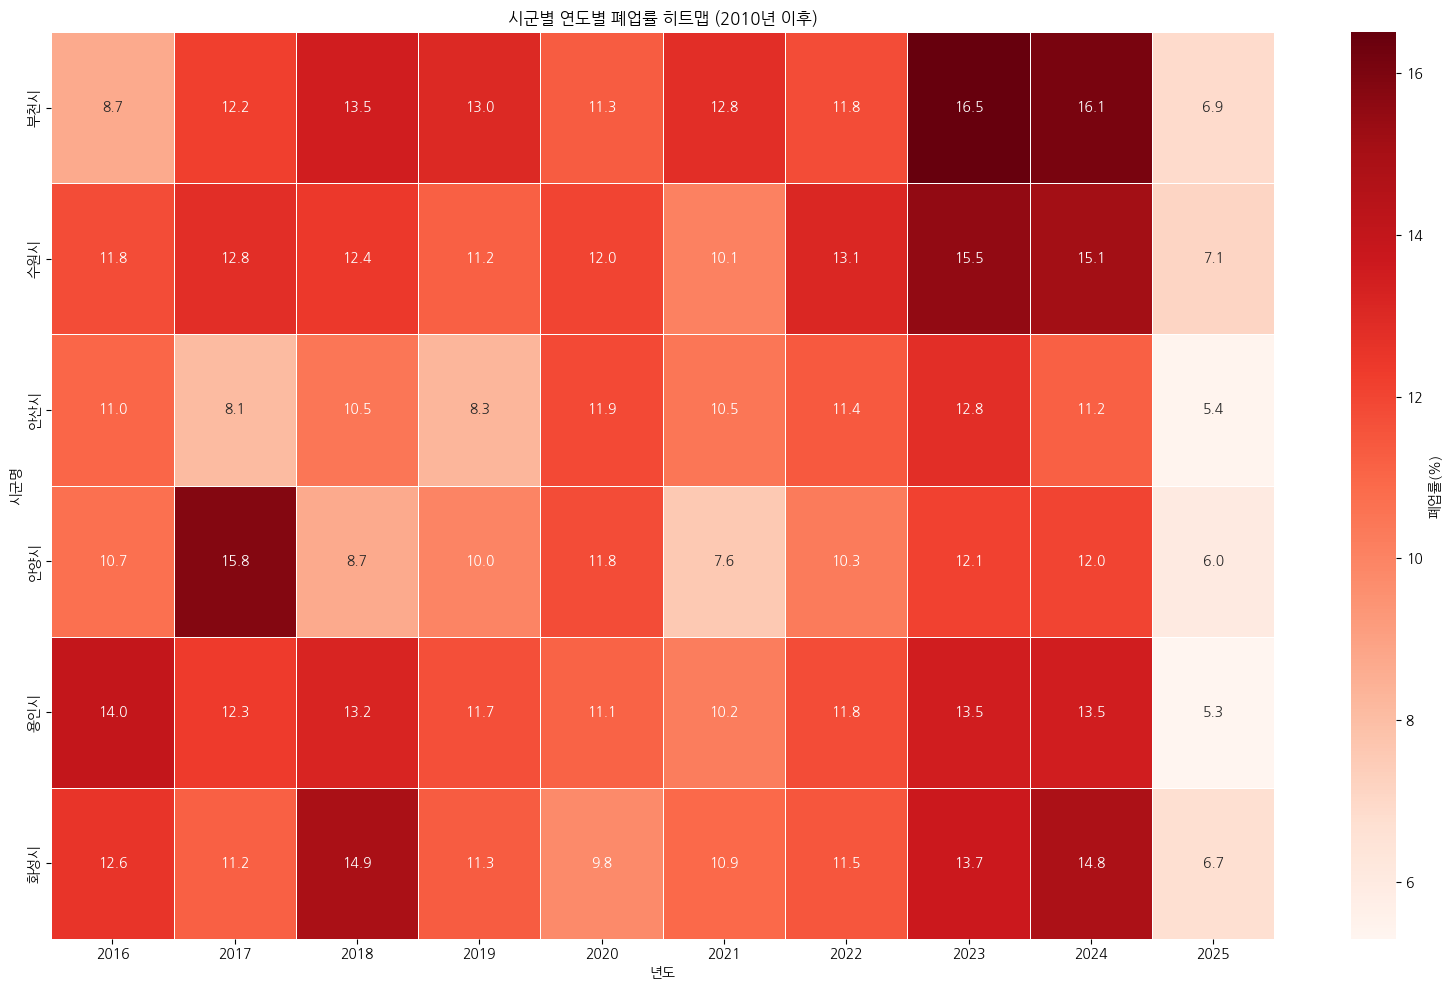

In [48]:
# 2010년 이후만 필터링
# df_filtered = result_df[result_df['년도'] >= 2010]

# 히트맵

# '구분'이 '통합'인 데이터만 선택
pivot_data = result_df[result_df['구분'] == '통합']

pivot_df = pivot_data.pivot(index='시군명', columns='년도', values='폐업률(%)')

plt.figure(figsize=(16, 10))
sns.heatmap(pivot_df, annot=True, fmt=".1f", cmap='Reds', linewidths=.5, cbar_kws={'label': '폐업률(%)'})
plt.title('시군별 연도별 폐업률 히트맵 (2010년 이후)')
plt.xlabel('년도')
plt.ylabel('시군명')
plt.tight_layout()
plt.show()



/tmp/ipython-input-1163125005.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_2023.sort_values(by='폐업률(%)', ascending=False), x='폐업률(%)', y='시군명', palette='Reds_r')


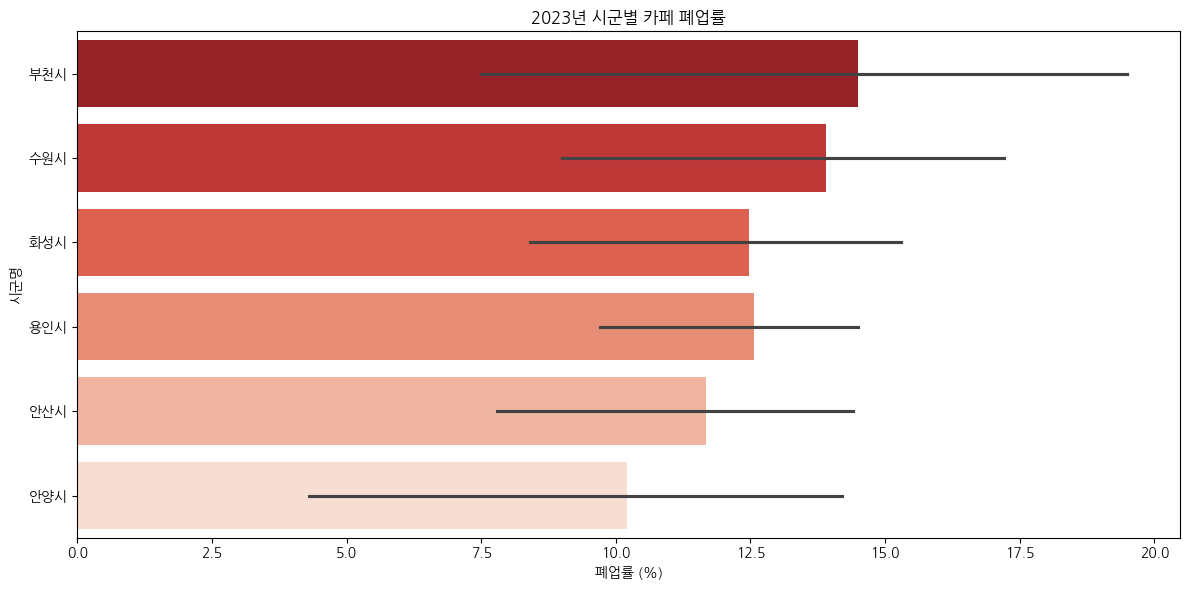

In [49]:
# 예시: 2023년만 시군별 비교
df_2023 = result_df[result_df['년도'] == 2023]

plt.figure(figsize=(12, 6))
sns.barplot(data=df_2023.sort_values(by='폐업률(%)', ascending=False), x='폐업률(%)', y='시군명', palette='Reds_r')
plt.title('2023년 시군별 카페 폐업률')
plt.xlabel('폐업률 (%)')
plt.ylabel('시군명')
plt.tight_layout()
plt.show()


/tmp/ipython-input-1384541901.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=result_df, x='폐업률(%)', y='시군명', palette='Set3')


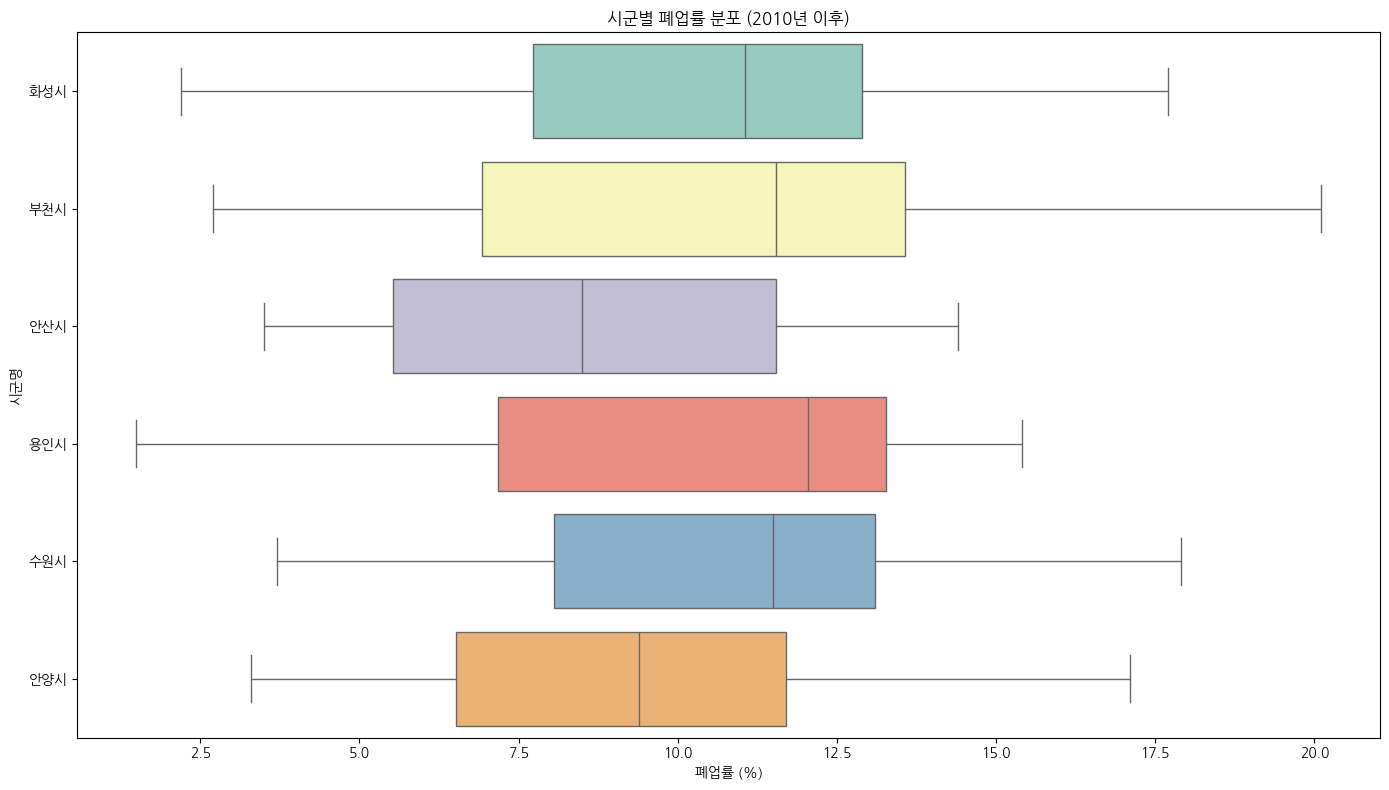

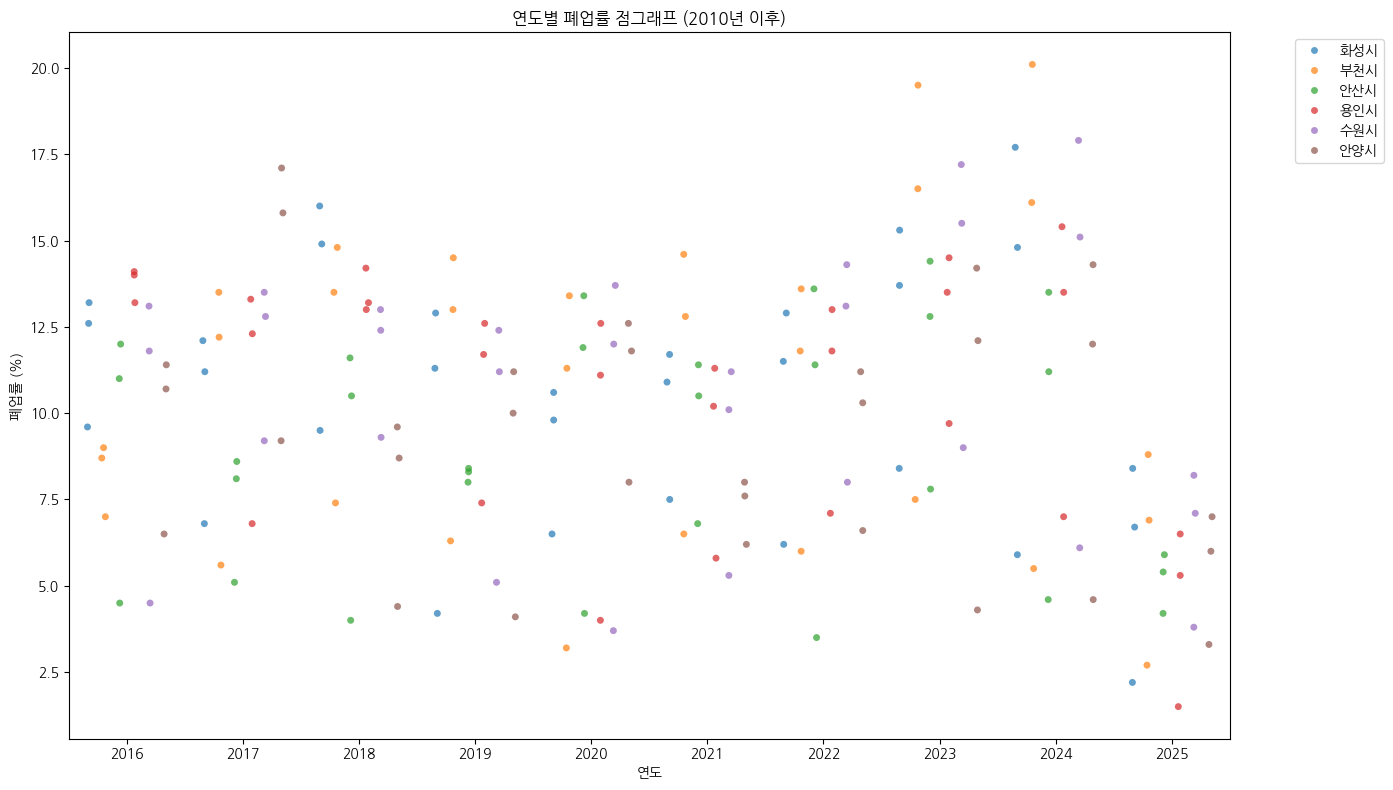

/tmp/ipython-input-1384541901.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_by_region.values, y=mean_by_region.index, palette="coolwarm")


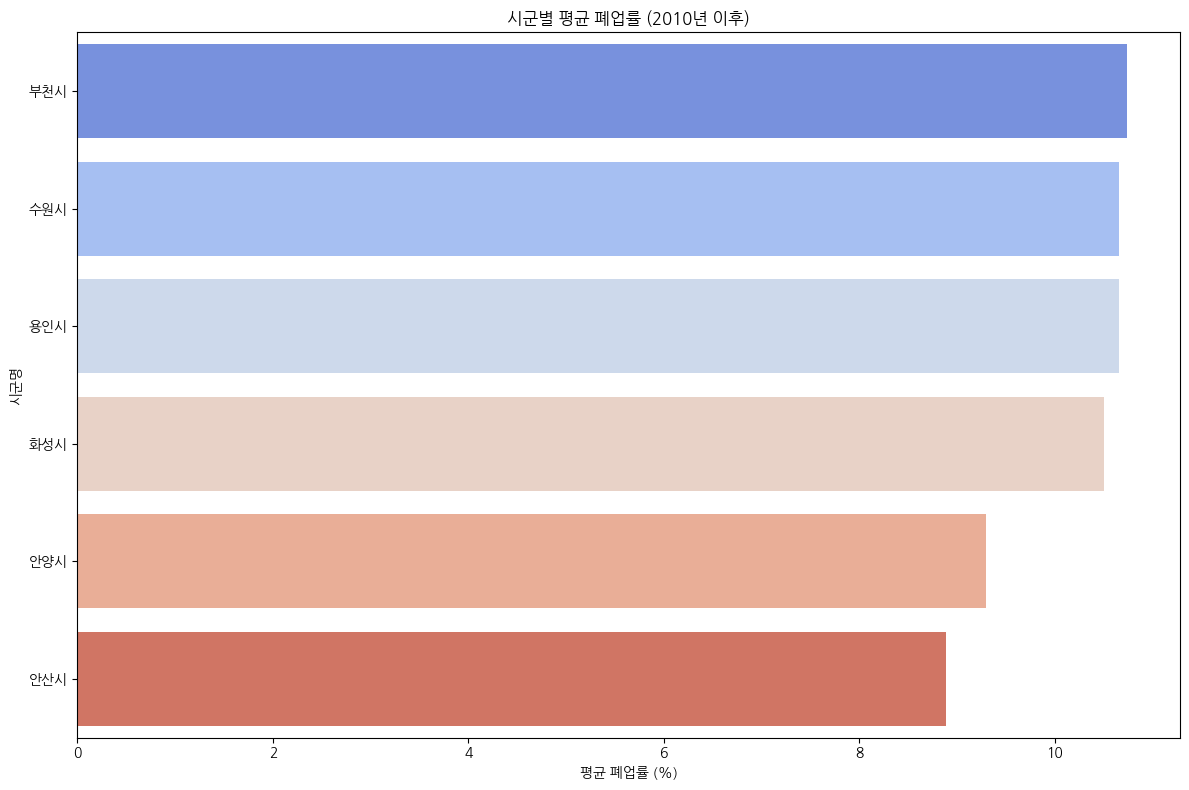

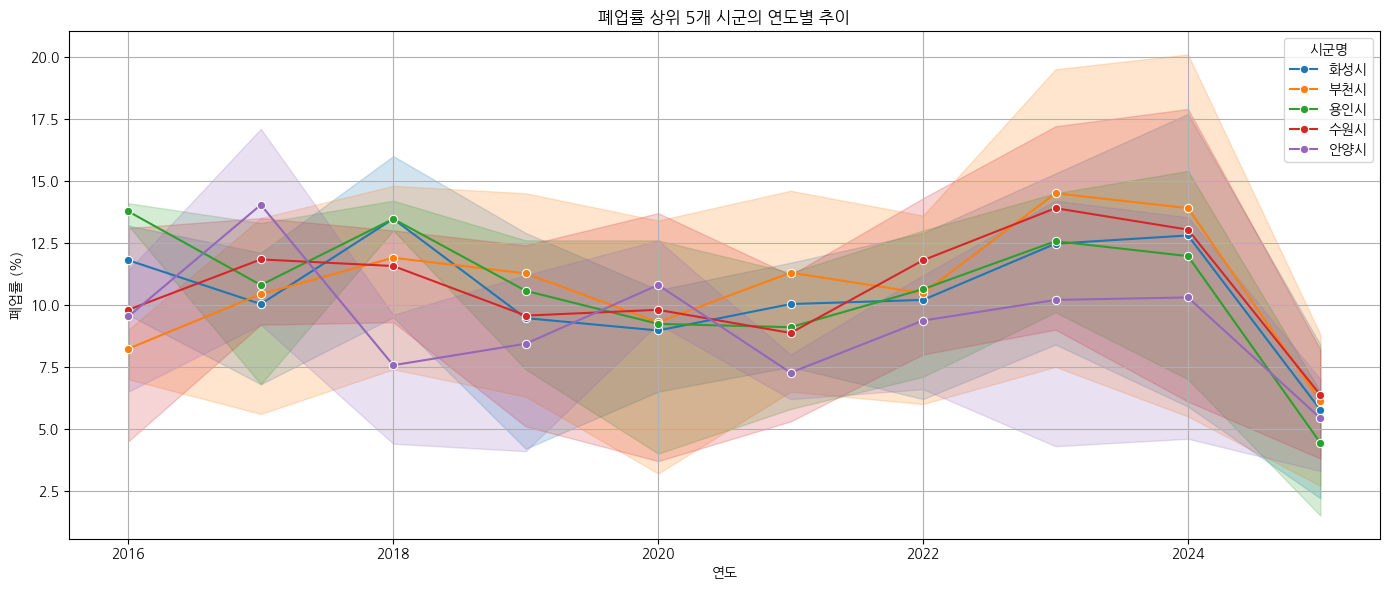

In [50]:
# 시각화 1: 박스플롯 - 시군별 폐업률 분포
plt.figure(figsize=(14, 8))
sns.boxplot(data=result_df, x='폐업률(%)', y='시군명', palette='Set3')
plt.title('시군별 폐업률 분포 (2010년 이후)')
plt.xlabel('폐업률 (%)')
plt.ylabel('시군명')
plt.tight_layout()
plt.show()

# 시각화 2: 점그래프 - 폐업률 트렌드
plt.figure(figsize=(14, 8))
sns.stripplot(data=result_df, x='년도', y='폐업률(%)', hue='시군명', dodge=True, jitter=True, alpha=0.7)
plt.title('연도별 폐업률 점그래프 (2010년 이후)')
plt.xlabel('연도')
plt.ylabel('폐업률 (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 시각화 3: 평균 폐업률 바그래프 (시군별 평균)
mean_by_region = result_df.groupby('시군명')['폐업률(%)'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=mean_by_region.values, y=mean_by_region.index, palette="coolwarm")
plt.title('시군별 평균 폐업률 (2010년 이후)')
plt.xlabel('평균 폐업률 (%)')
plt.ylabel('시군명')
plt.tight_layout()
plt.show()

# 시각화 4: 상위 5개 시군만 라인 차트
top5_regions = mean_by_region.head(5).index.tolist()
top5_df = result_df[result_df['시군명'].isin(top5_regions)]

plt.figure(figsize=(14, 6))
sns.lineplot(data=top5_df, x='년도', y='폐업률(%)', hue='시군명', marker='o')
plt.title('폐업률 상위 5개 시군의 연도별 추이')
plt.xlabel('연도')
plt.ylabel('폐업률 (%)')
plt.grid(True)
plt.tight_layout()
plt.show()